In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from bumps.names import *
from bumps.fitters import fit

import sasmodels

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

import sys

# set path to sasview source code if necessary for your operating system/environment
# sys.path.append(r'\\Users\\sages\\Desktop\\DataScience\\all_sasmodels\\sasview\\src')
import sas

In [2]:
# sample meta-data
sample_info = pd.read_csv('../Sample_Info.csv')

# helpful meta-data dictionaries
names = dict(zip(sample_info['Sample'], sample_info['Name']))
cps = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer']))
matrix = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer']))
solvent_names = dict(zip(sample_info['Sample'], sample_info['Solvent']))

# target weight percents of conjugated polymer
target = dict(zip(sample_info['Sample'], sample_info['Target Fraction']*100))

# fixing 401/402 and 403/404 sample pair target values for plotting colors only
target[401] = 0.5
target[402] = 0.1
target[403] = 5
target[404] = 1

# actual weight percentages
data = np.loadtxt('../../uv_vis/Corrected_wtPercents.csv', delimiter=',', skiprows=1)
actual = {}
for key, tar, act, stdev, act_vol, stdev_vol in data:
    actual[key] = act_vol


In [3]:
data_dir = '../Smeared_Data_20200629/'
files = os.listdir(data_dir)
sans_data = {}
usans_data = {}
for file in files:
    if 'USANS' in file:
        key = int(file.split('_')[0][3:])
        usans_data[key] = load_data(data_dir + file)
    elif 'SANS' in file:
        key = int(file.split('_')[0][3:])
        sans_data[key] = load_data(data_dir + file)

In [4]:
# useful dictionaries with labels and colors for the plots and their legends
wt_names = {} 
full_names = {}

wt_colors = {}
solvent_colors = {}
cp_colors = {}

rep_colors = {}
rep_names = {}

temp_wt_colors = {
    0.1: 'firebrick',
    0.5: 'darkorange',
    1.0: 'darkcyan',
    5.0: 'mediumblue',
    10.0: 'deeppink',
    25.0: 'darkorchid',
    50.0: 'forestgreen',
    0.0: 'black'
}

temp_solvent_colors = {
    'Chloroform': 'firebrick',
    'Bromobenzene': 'darkorange',
    'Toluene': 'darkcyan',
    'Slow Dry Chloroform': 'forestgreen'
}

temp_cp_colors = {
    'RRe-P3HT': 'firebrick',
    'RRa-P3HT': 'darkorange',
    'P3DDT': 'forestgreen',
    'PQT-12': 'darkcyan',
    'None': 'black'
}

for key in names.keys():
    if key in actual.keys():
        frac = actual[key]
    else:
        frac = target[key]
    frac = np.round(frac,2)
    
    if cps[key] == 'None':
        wt_names[key] = matrix[key] + ' Control'
        full_names[key] = matrix[key] + ' Control'
    else:
        wt_names[key] = str(frac) + ' wt% ' + cps[key]
        full_names[key] = str(frac) + ' wt% ' + cps[key] + ' in ' + matrix[key]
        
for key in cps.keys():
    wt_colors[key] = temp_wt_colors[target[key]]
    solvent_colors[key] = temp_solvent_colors[solvent_names[key]]
    cp_colors[key] = temp_cp_colors[cps[key]]


Loading polystyrene fit information.

In [5]:
background_files = [file for file in os.listdir('../PS_Fitting/ps_fit_results/power_law_background') if 'json' in file]
backgrounds = {} # key is sample key, value is ('best', '95% confidence interval')
for file in background_files:
    data_read = pd.read_json('../PS_Fitting/ps_fit_results/power_law_background/' + file)
    key = int(file.split('_')[0][3:])
    p95 = data_read.loc['p95',str(key) + ' background']
    backgrounds[key] = (data_read.loc['best',str(key) + ' background'], p95)

In [6]:
power_law_fit_info = pd.read_json('../PS_Fitting/ps_fit_results/power_law_porod_exp_scale/PS_porod_exp_scale-err.json')
scales = {}

for key, value in power_law_fit_info.items():
    if 'porod_exp' in key:
        ps_porod_exp = value['best']
        ps_porod_95p = value['p95']
    else:
        key = int(key.split()[0])
        scales[key] = (value['best'], value['p95'])

In [7]:
guinier_porod_fit = pd.read_json('../PS_Fitting/ps_fit_results/guinier_porod_s_scale/PS_s_scale-err.json')
rgs = {}
for key, value in guinier_porod_fit.items():
    if key == 'ps s':
        ps_s = value['best']
        ps_s_95 = value['p95']
    elif 'rg' in key:
        key = int(key.split()[0])
        rgs[key] = (value['best'], value['p95'])
    elif 'scale' in key:
        key = int(key.split()[0])
        scales[key] = (value['best'], value['p95'])
        

# steps: 33334, # draws: 1000020
step 1 cost 7477259837558.914(27)
                            101 PS scale |.........  0.0999994 in (0,1)
                            101 CP scale |.........  0.0999992 in (0,1)
                          101 background |.........  0.0699959 in (0,10)
step 30 cost 189419181.152(27)
step 54 cost 53956438.463(27)
step 75 cost 1880352.348(27)
final chisq 1880352.348(27)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                            101 PS scale 97.47(15)e-6    97.47176(11)e-6
                            101 CP scale 29.941(25)e-6   29.940552(18)e-6
                          101 background 1.97824(22)     1.97823892(16) 
              Parameter       mean  median    best [   68% interval] [   95% interval]
 1         101 PS scale  44(49)e-3   0.019   0.000 [   0.00    0.10] [   0.00    0.17]
 2         101 CP scale  21(34)e-3  0.0020  0.0000 [  0.000   0.067] [  0.000   0.100]
 3       101 background   0.46(69)   0.

/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/varplot.py:248: RuntimeWarning: divide by zero encountered in true_divide
  maxlikelihood *= np.sum(height)/np.sum(maxlikelihood)
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/varplot.py:248: RuntimeWarning: invalid value encountered in multiply
  maxlikelihood *= np.sum(height)/np.sum(maxlikelihood)


# steps: 33334, # draws: 1000020
step 1 cost 1400774676511.821(29)
                            102 PS scale |.........  0.0999993 in (0,1)
                            102 CP scale |.........   0.099999 in (0,1)
                          102 background |.........  0.0699952 in (0,10)
step 31 cost 118624913.940(29)
step 57 cost 33154919.060(29)
step 75 cost 3130488.172(29)
step 100 cost 235707.063(29)
step 117 cost 166652.205(29)
step 140 cost 12068.612(29)
step 167 cost 5240.319(29)
step 186 cost 818.163(29)
step 210 cost 137.765(29)
step 235 cost 137.765(29)
final chisq 48.367(29)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                            102 PS scale 0.89(38)e-6     888(55)e-9     
                            102 CP scale 236(78)e-9      236(11)e-9     
                          102 background 0.08279(23)     0.082787(33)   
              Parameter       mean  median    best [   68% interval] [   95% interval]
 1         102 PS scale  11(

/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/varplot.py:248: RuntimeWarning: divide by zero encountered in true_divide
  maxlikelihood *= np.sum(height)/np.sum(maxlikelihood)
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/varplot.py:248: RuntimeWarning: invalid value encountered in multiply
  maxlikelihood *= np.sum(height)/np.sum(maxlikelihood)
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/varplot.py:248: RuntimeWarning: divide by zero encountered in true_divide
  maxlikelihood *= np.sum(height)/np.sum(maxlikelihood)
/Applications/anaconda/envs/sasmodels2/lib/python3.8/site-packages/bumps/dream/varplot.py:248: RuntimeWarning: invalid value encountered in multiply
  maxlikelihood *= np.sum(height)/np.sum(maxlikelihood)


KeyboardInterrupt: 

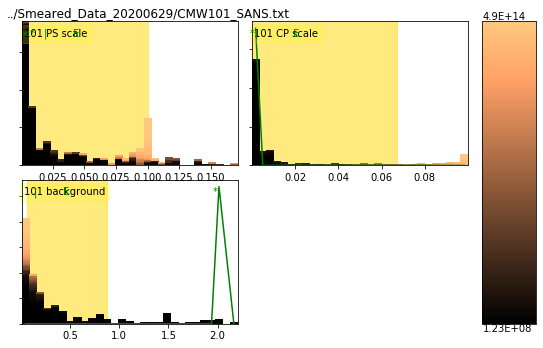

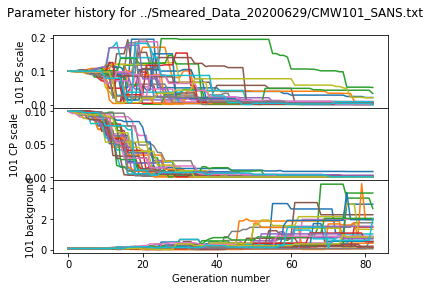

Error in callback <function flush_figures at 0x11b459f70> (for post_execute):


KeyboardInterrupt: 

In [12]:
# storing the parameters for use in this notebook
# parameters will also get stored to the directory
params = {}
# storing the fitting problems
results = {}

# will utilize the power_law model in SasView
# as the porod model automatically enforces an exponent of 4
# power_law_A will be polystyrene contribution
# power_law_B will be conjugated polymer contribution
kernel=load_model("power_law+power_law")

sample_keys = [x for x in sans_data.keys() if target[x] > 0 and matrix[x] == 'Polystyrene-D8']

# cp_power is an assumed parameter, if this changes, all notebooks
# will need to be modified in this directory with the new value
cp_power = Parameter(4.0, name = 'CP porod_exp')
ps_power = Parameter(ps_porod_exp, name = 'PS porod_exp') # from ps fits

for key in sample_keys:
    
    # loading the data
    sans = sans_data[key]
    
    # initial parameter values
    scale = Parameter(1, name = str(key) + ' scale')
    background = Parameter(0.07, name = str(key) + ' background')
    A_scale = Parameter(0.1, name = str(key) + ' PS scale')
    B_scale = Parameter(0.1, name = str(key) + ' CP scale')
    
    # storing the fit parameters
    params[key] = {}
    params[key]['background'] = background
    params[key]['A_scale'] = A_scale
    params[key]['B_scale'] = B_scale

    # setting up the power_law model for fitting
    sans_model = Model(kernel, scale=scale, background=background,  A_scale=A_scale, B_scale=B_scale, A_power=ps_power, B_power=cp_power)

    # setting parameter ranges as needed
    sans_model.background.range(0,10)
    sans_model.A_scale.range(0,1)
    sans_model.B_scale.range(0,1)

    # common minimum q for the porod analysis
    sans.qmin = 2e-2
    if cps[key] == 'RRe-P3HT':
        if target[key] > 1:
            sans.qmin = 4e-2
        elif target[key] > 0.1:
            sans.qmin = 3e-2
        
    mask = np.where(sans.x >= sans.qmin)
    sans.x = sans.x[mask]
    sans.y = sans.y[mask]
    sans.dx = sans.dx[mask]
    sans.dy = sans.dy[mask]
    sans.mask = sans.mask[mask]
    
    sans.dx = sans.dx-sans.dx # removing any smeared contributions for the sans contribution

    experiment=Experiment(data=sans, model=sans_model)
    
    problem=FitProblem(experiment)
    result=fit(problem,method='dream', samples=1e6, verbose=True)
    #result.state.show(figfile='porod_results/CMW' + str(key) + '_porod_analysis')
    plt.close()

    results[key] = problem


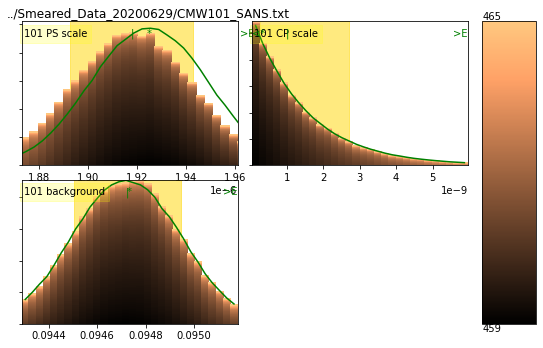

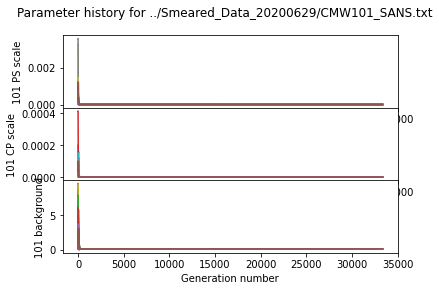

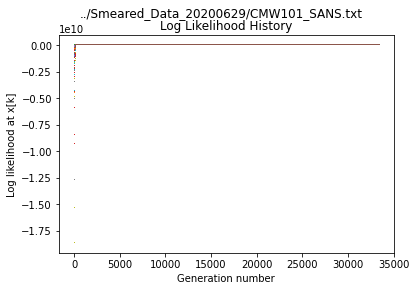

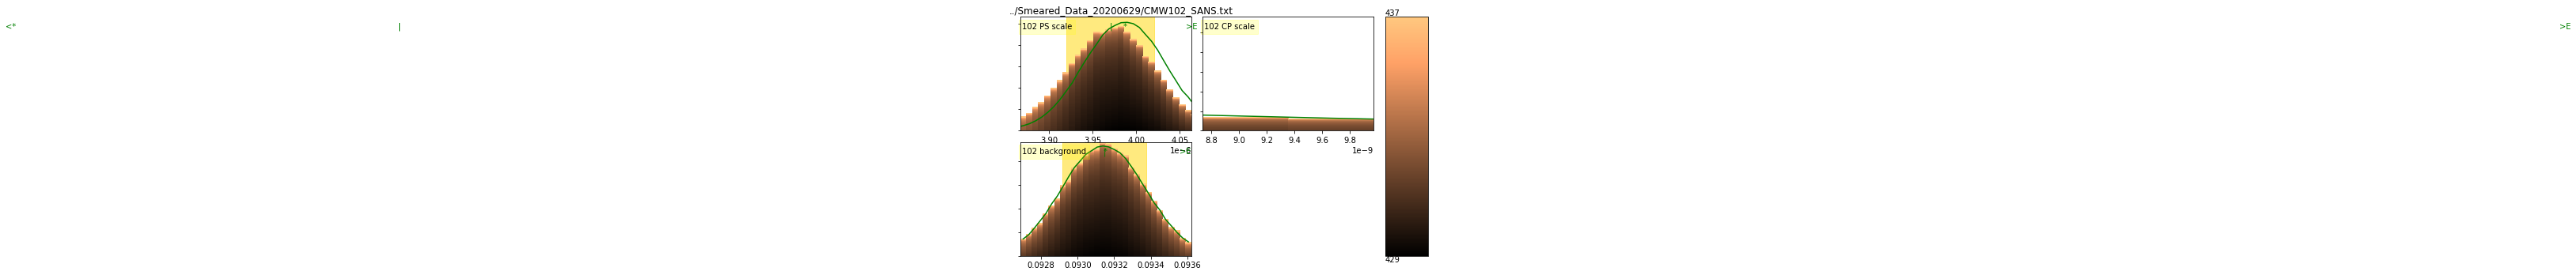

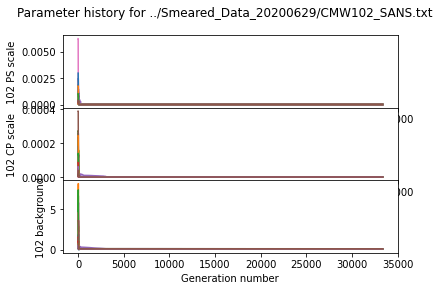

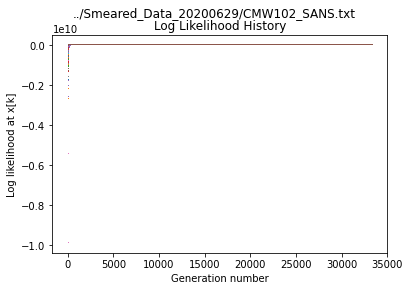

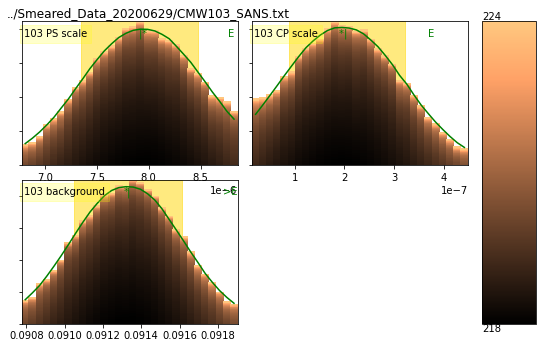

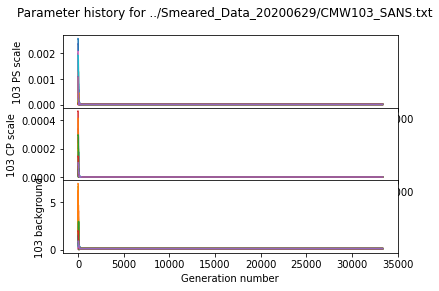

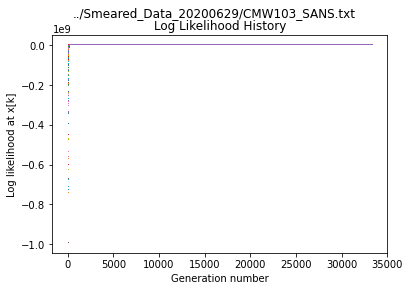

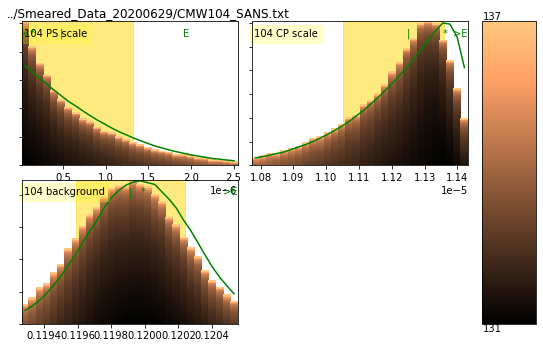

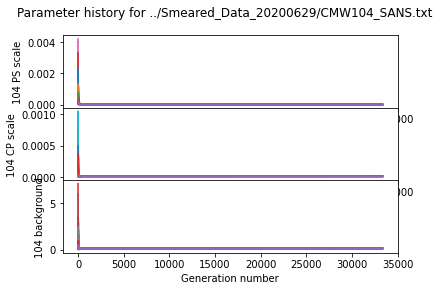

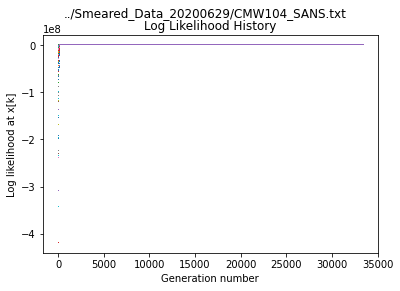

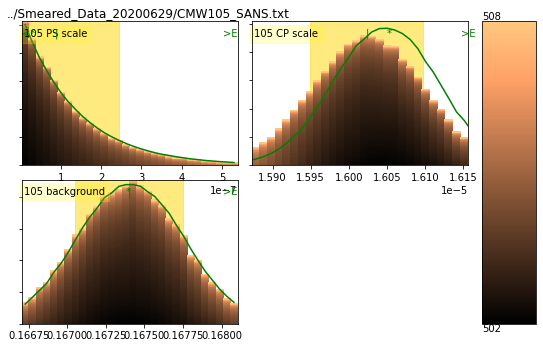

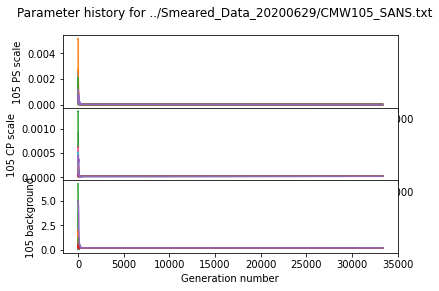

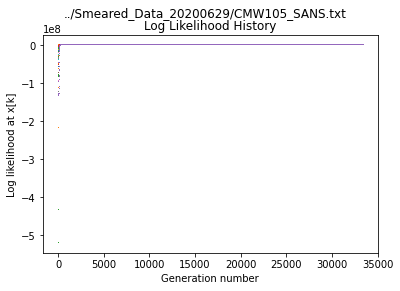

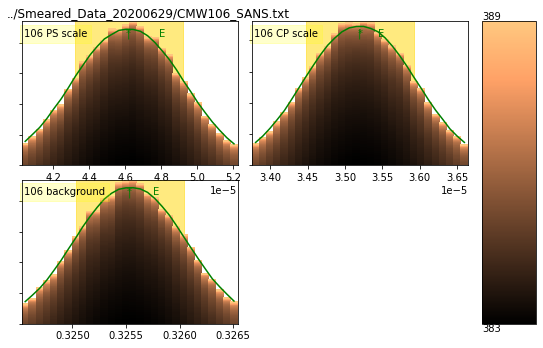

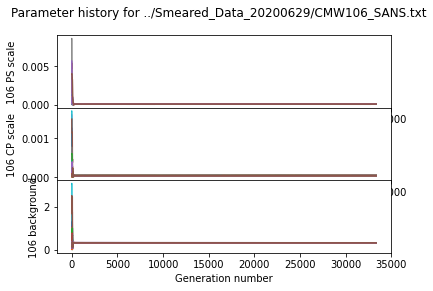

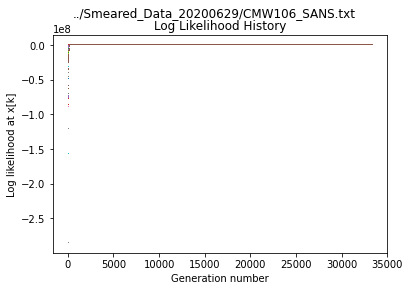

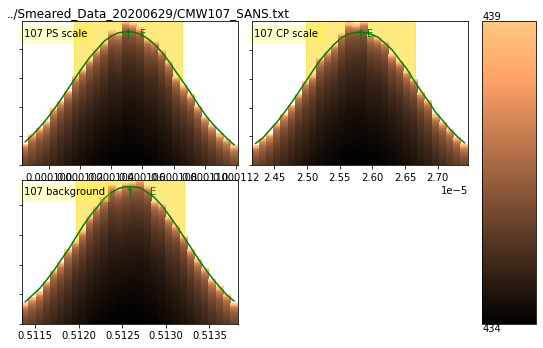

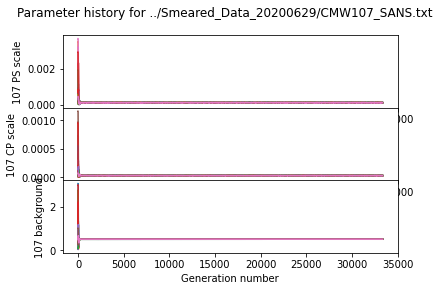

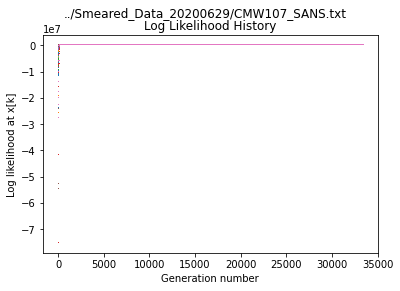

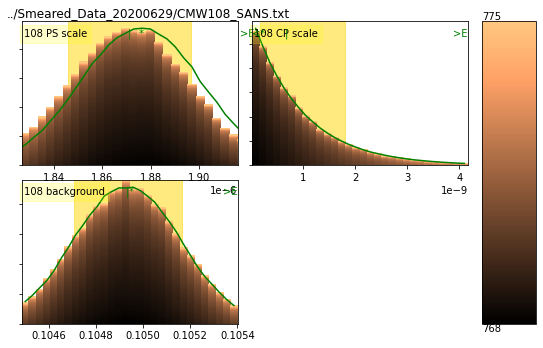

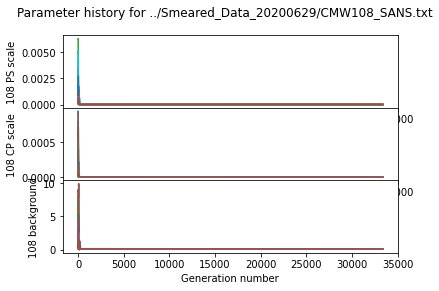

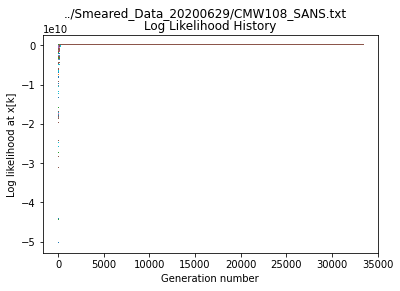

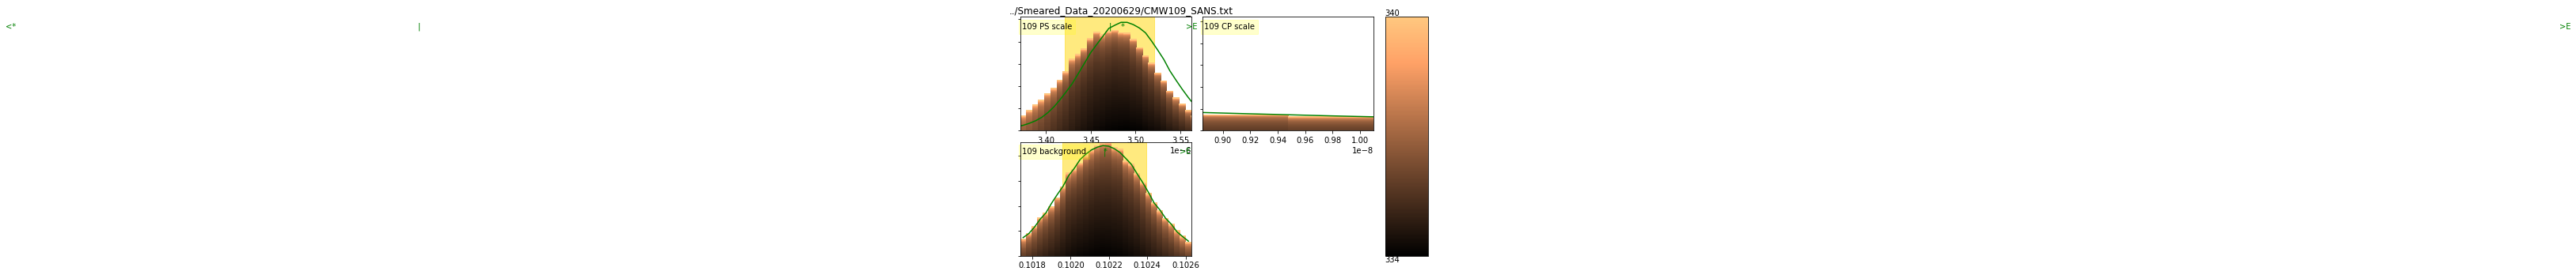

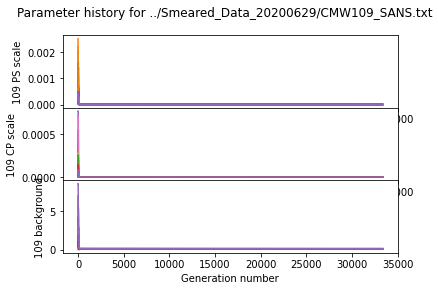

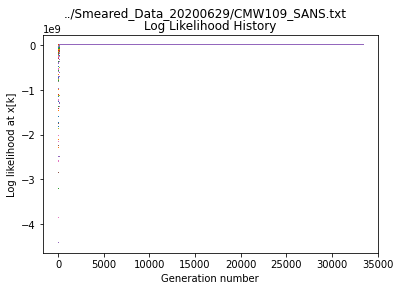

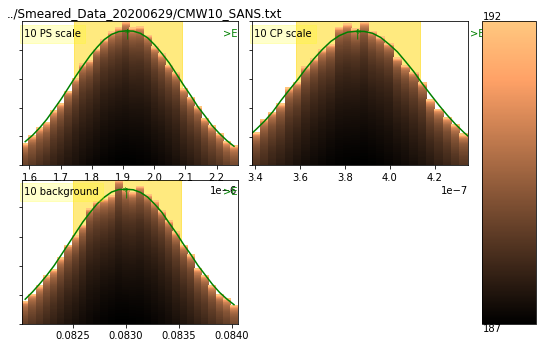

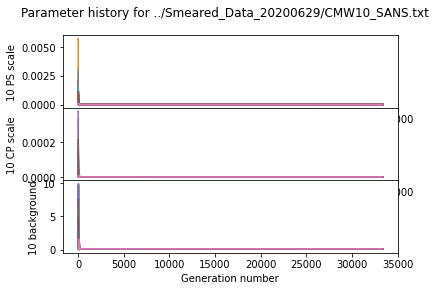

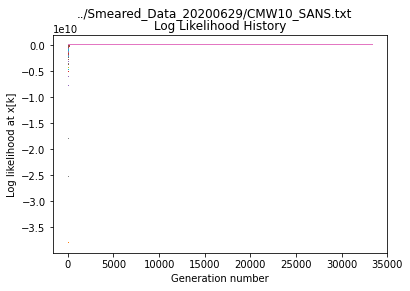

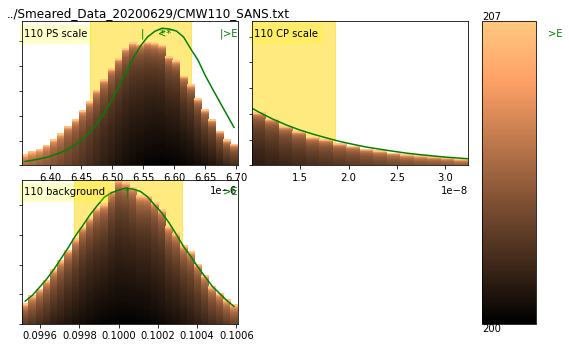

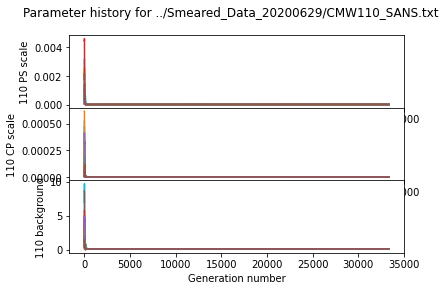

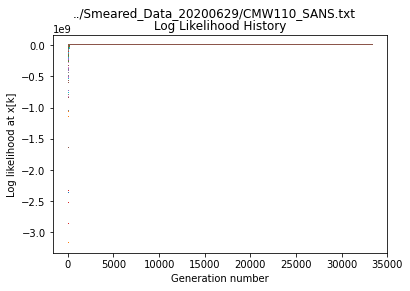

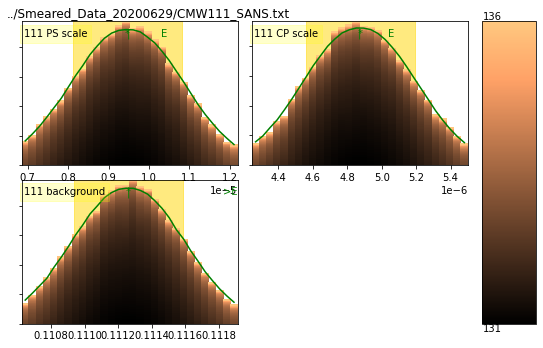

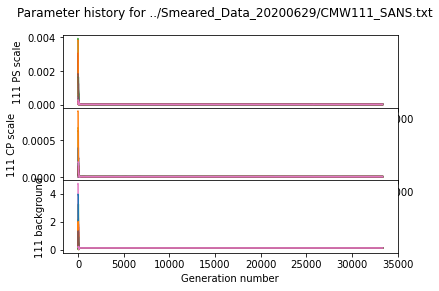

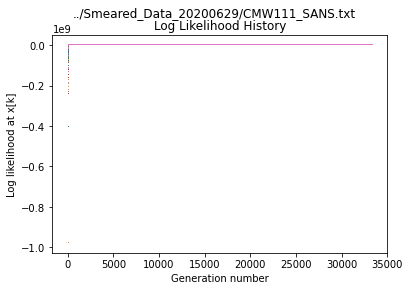

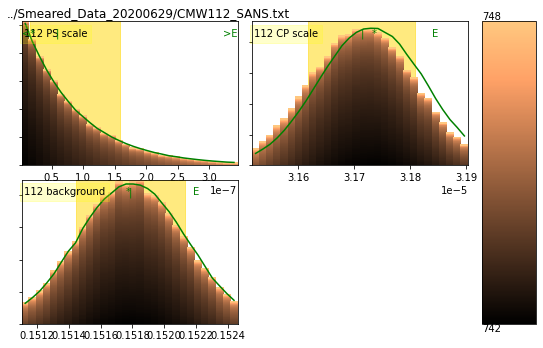

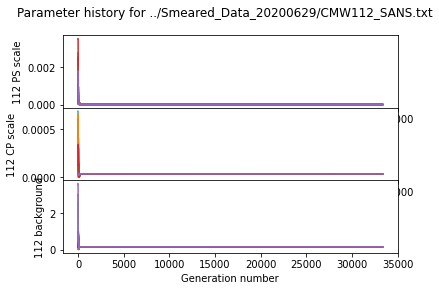

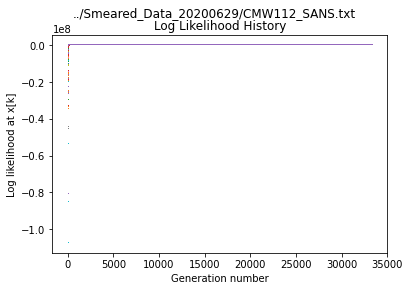

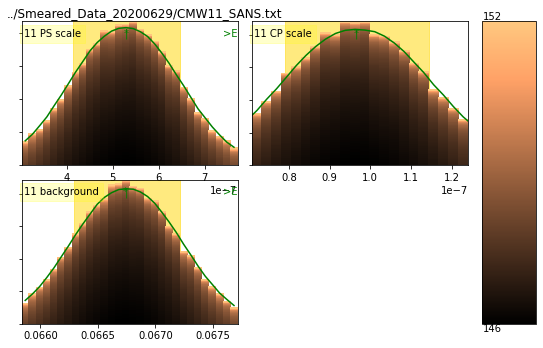

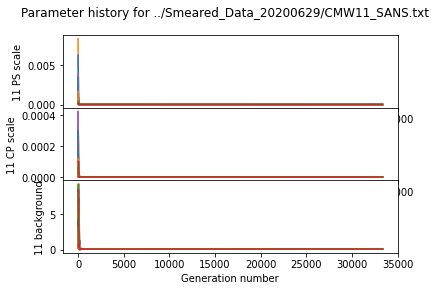

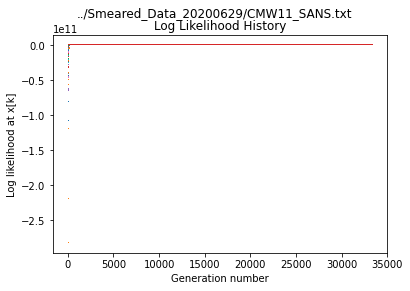

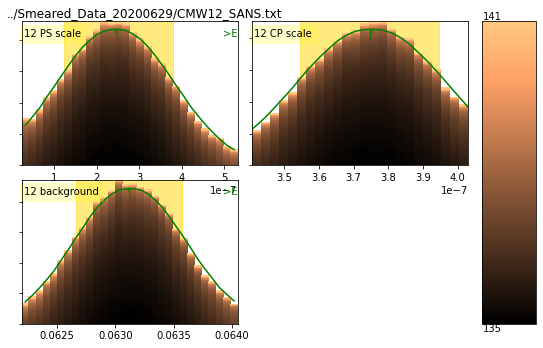

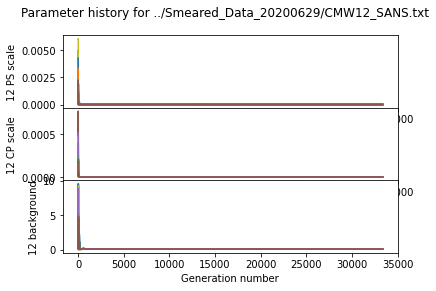

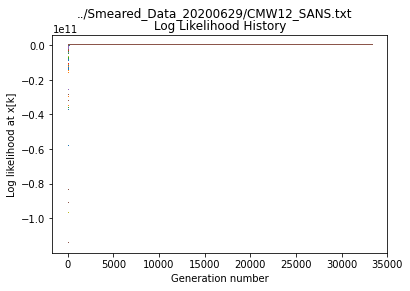

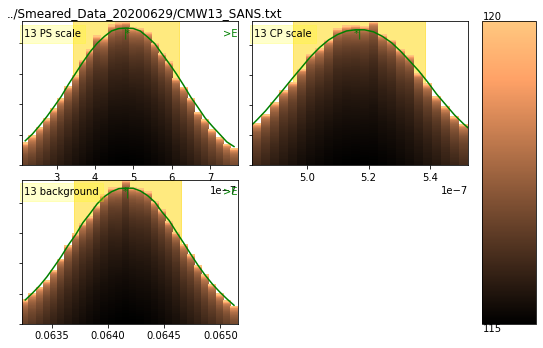

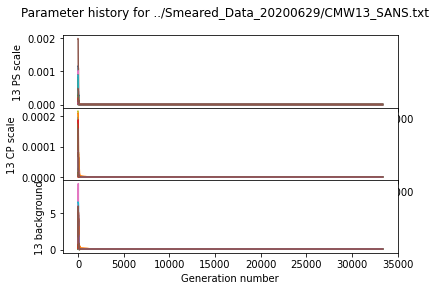

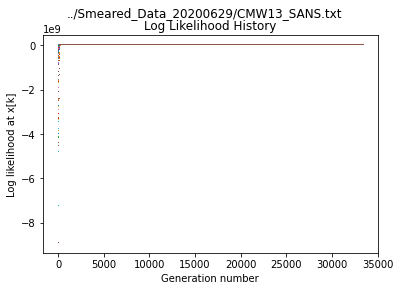

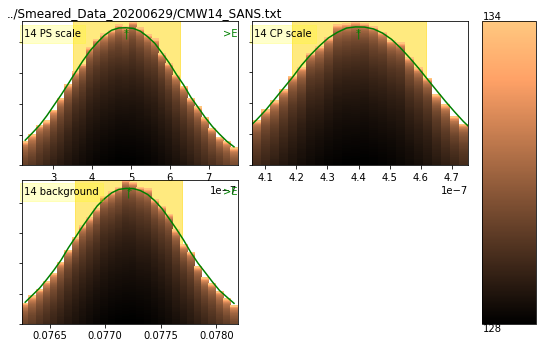

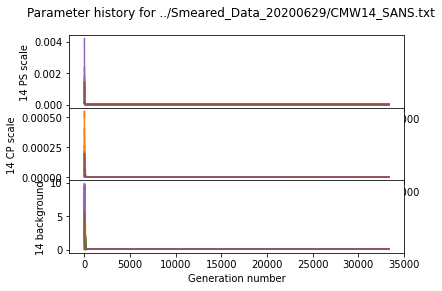

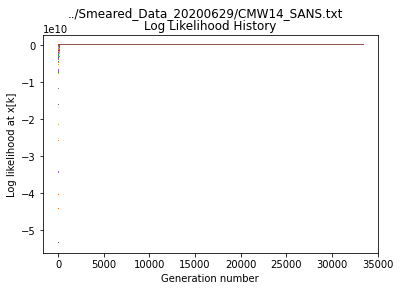

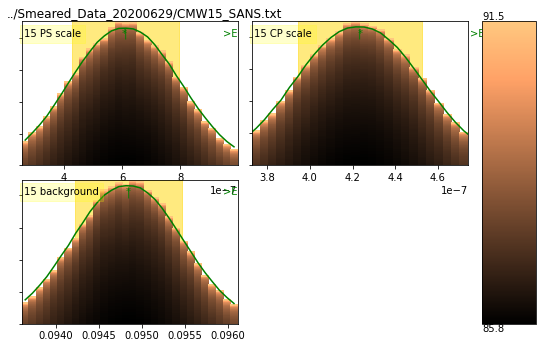

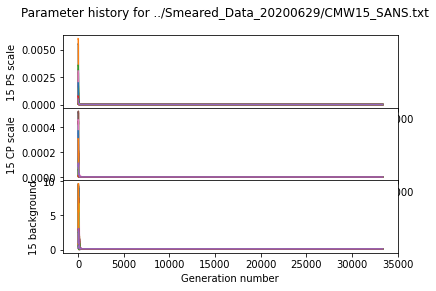

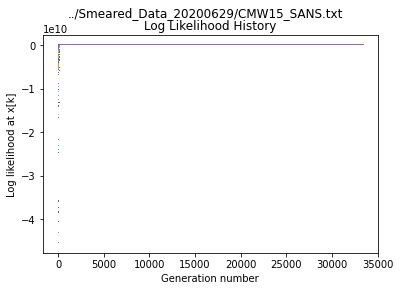

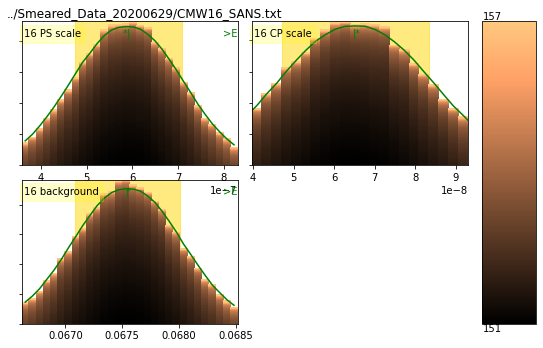

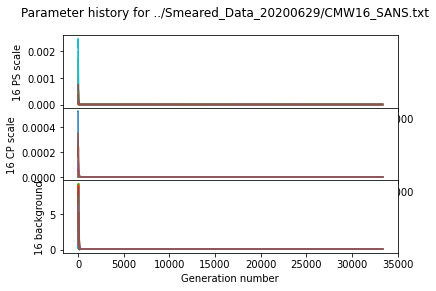

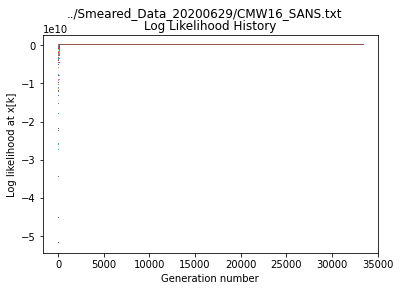

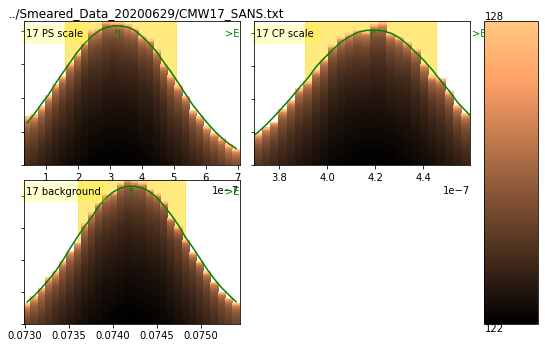

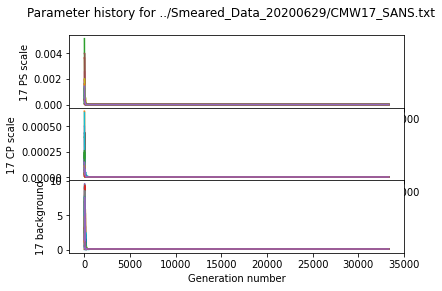

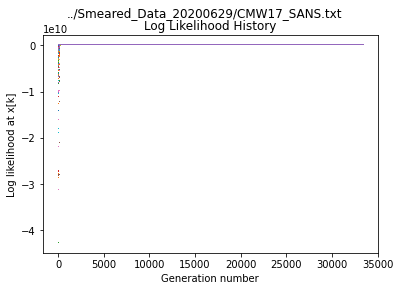

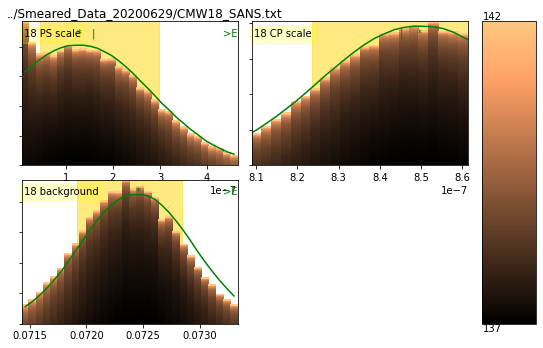

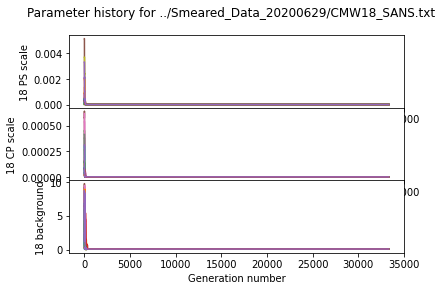

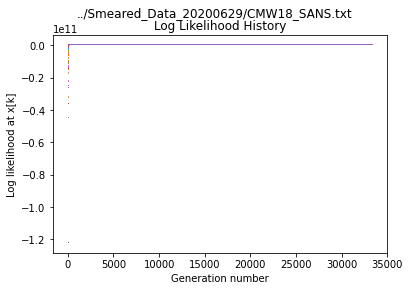

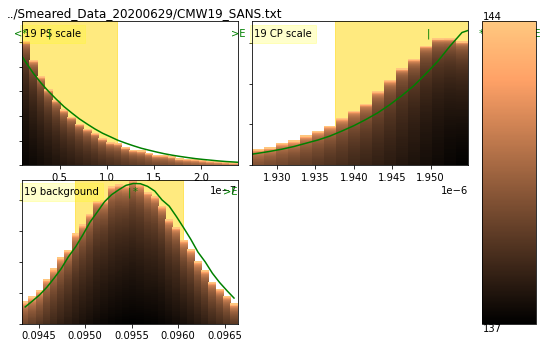

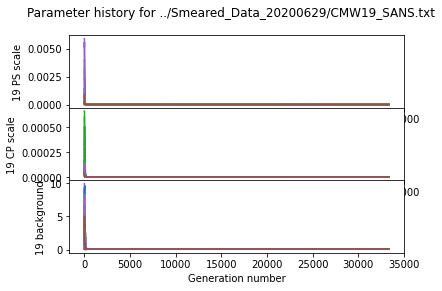

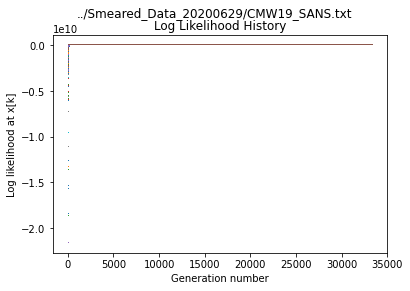

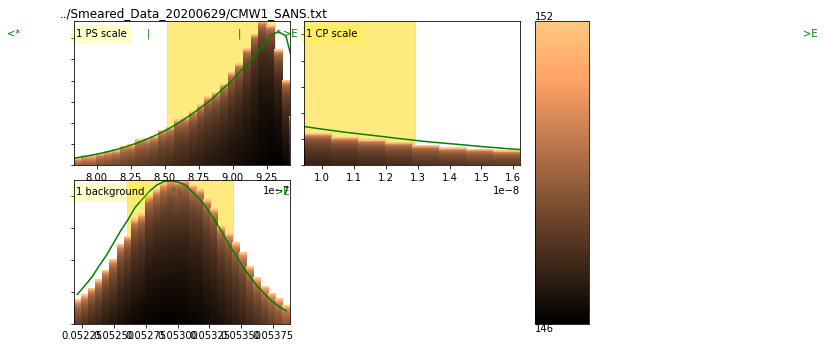

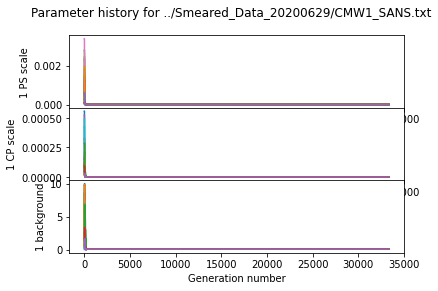

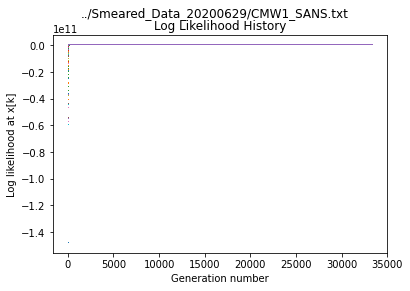

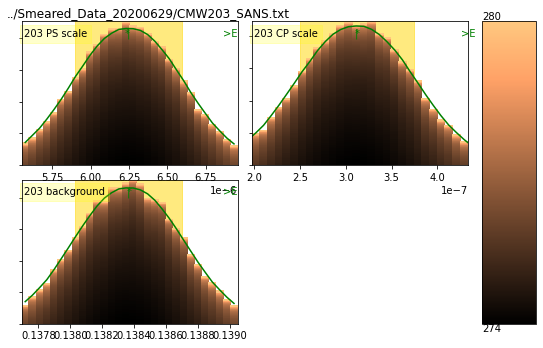

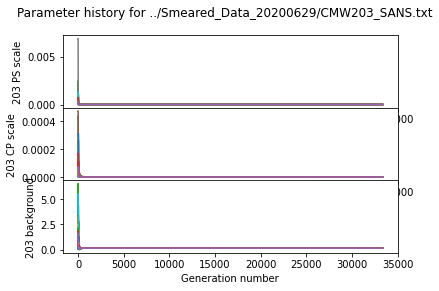

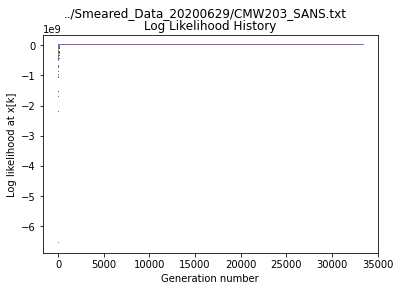

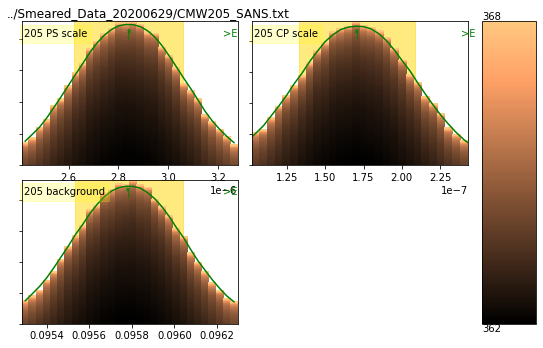

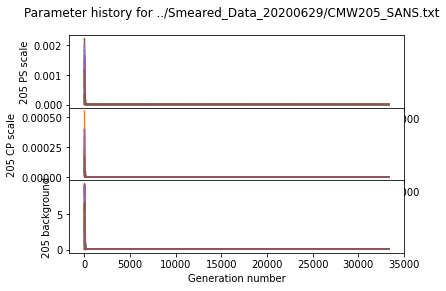

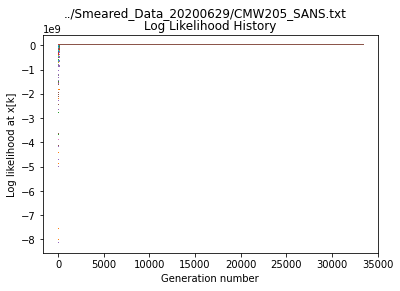

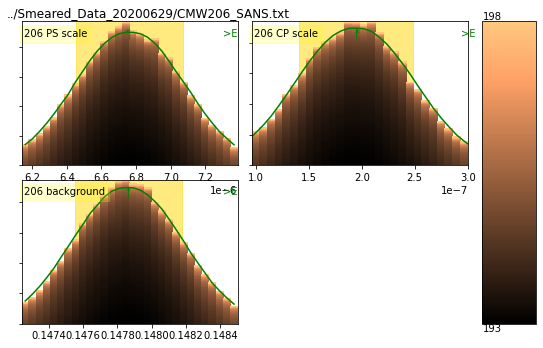

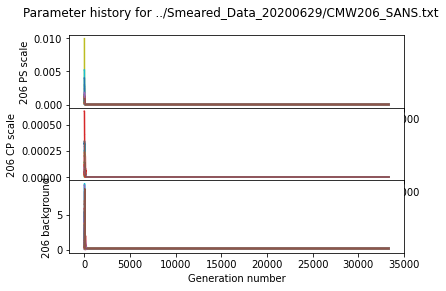

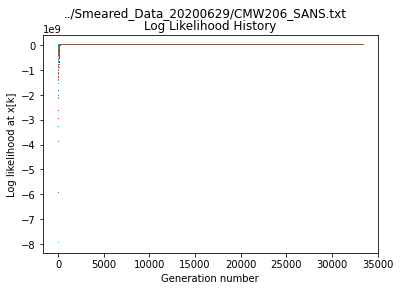

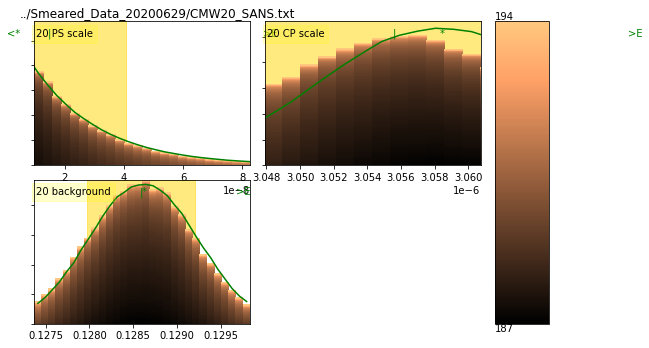

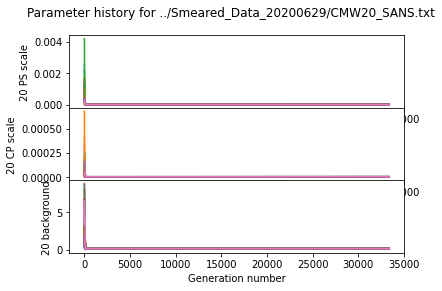

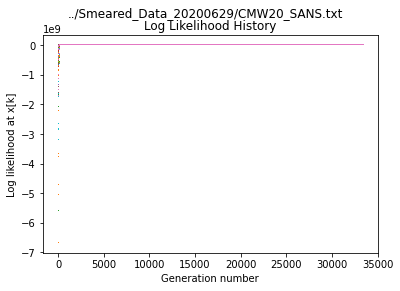

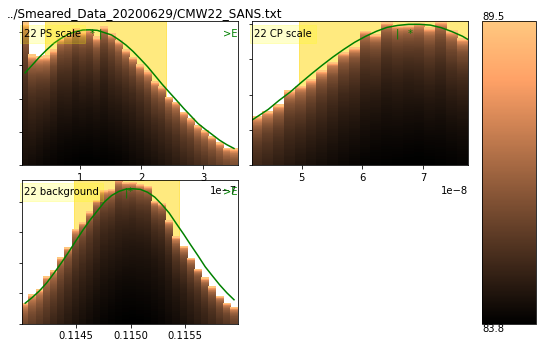

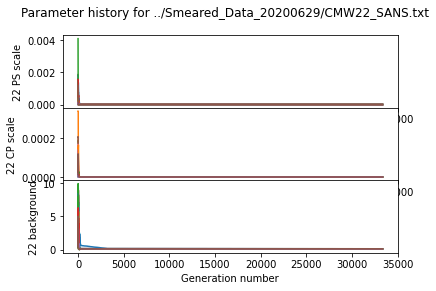

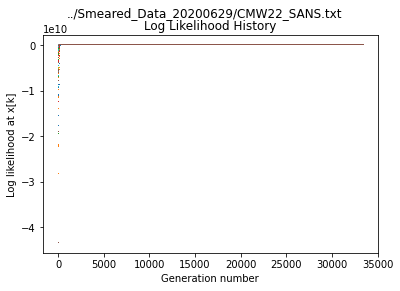

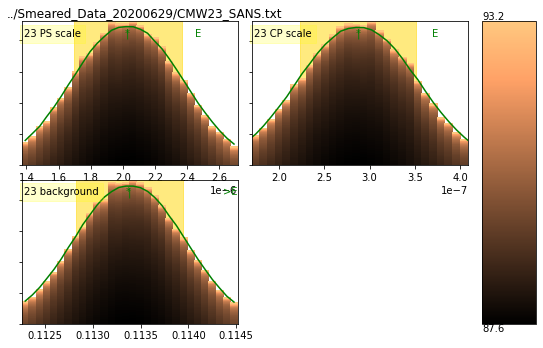

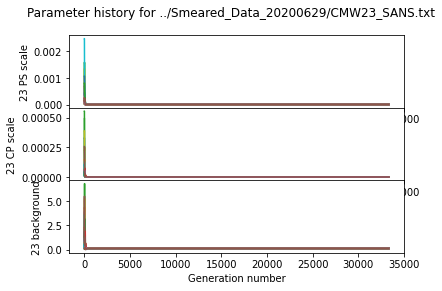

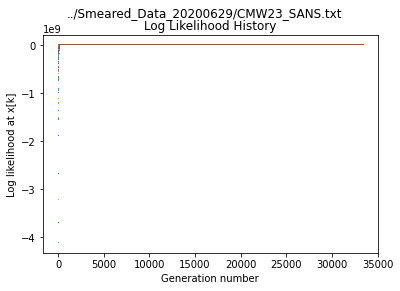

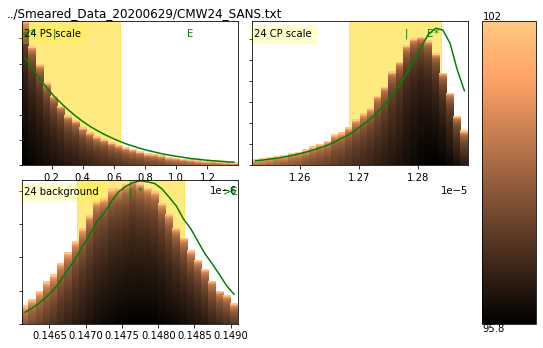

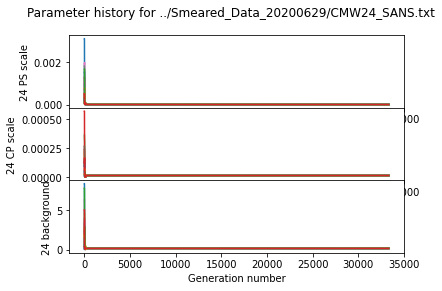

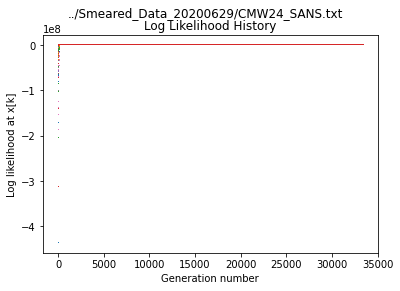

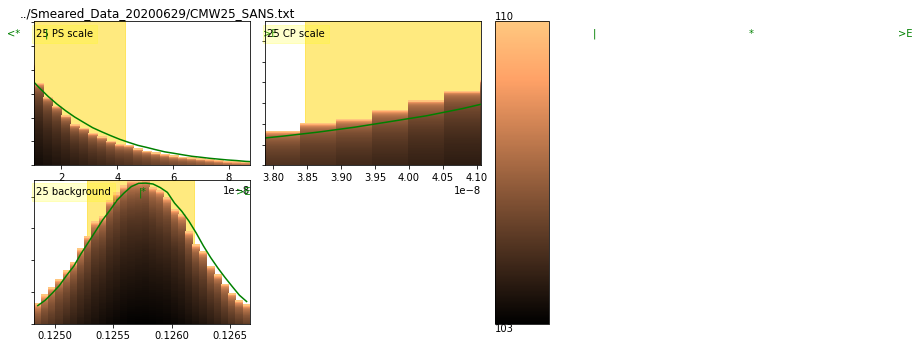

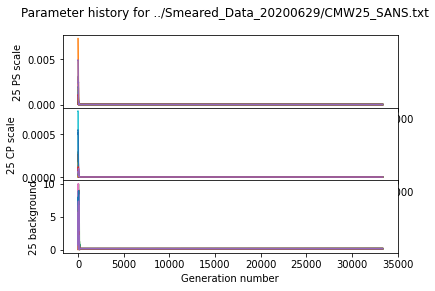

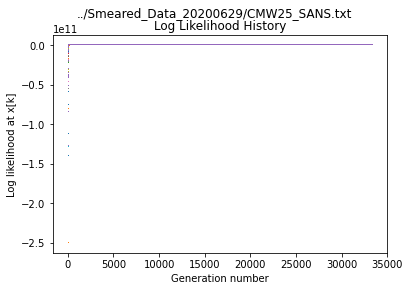

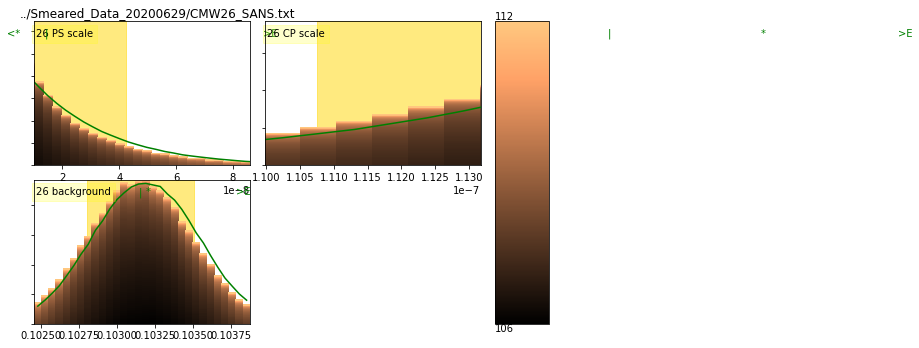

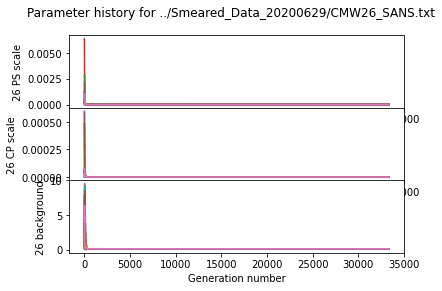

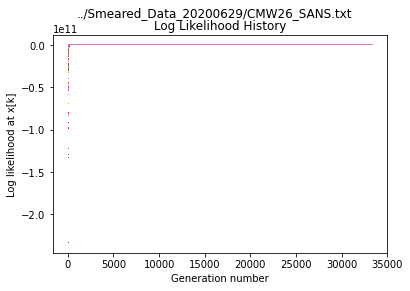

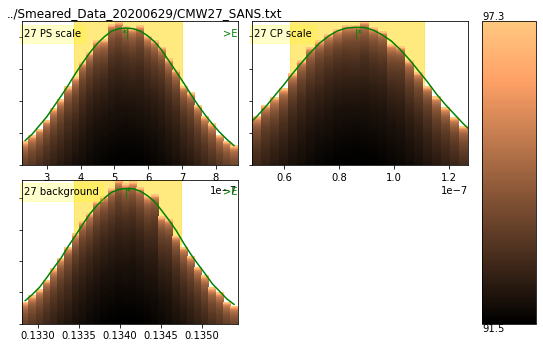

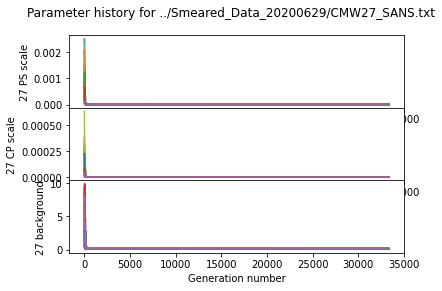

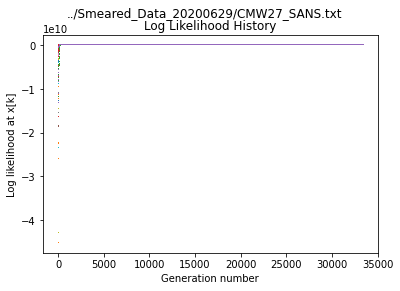

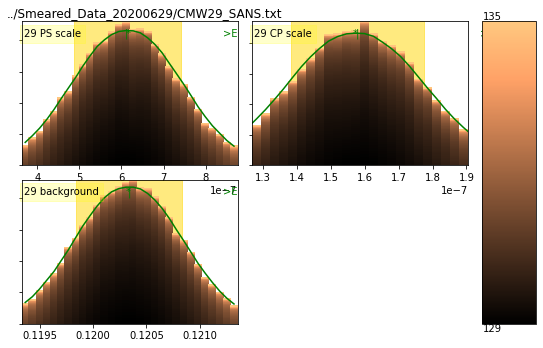

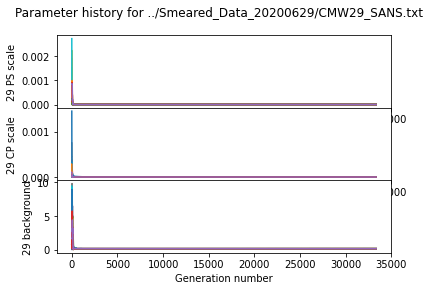

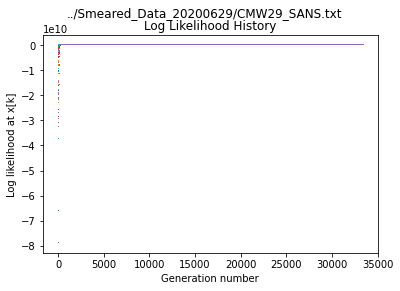

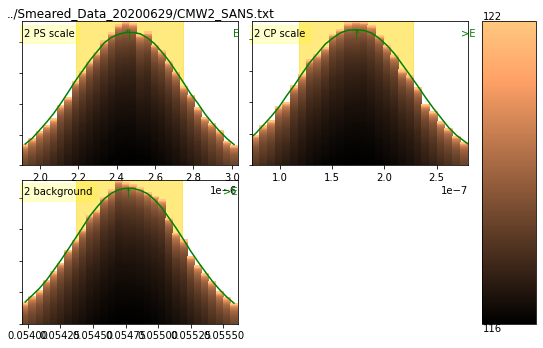

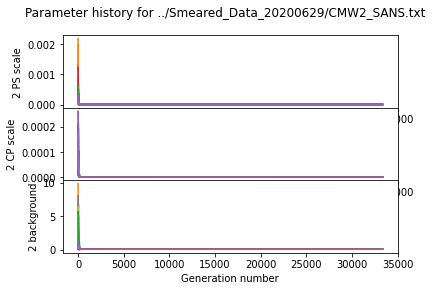

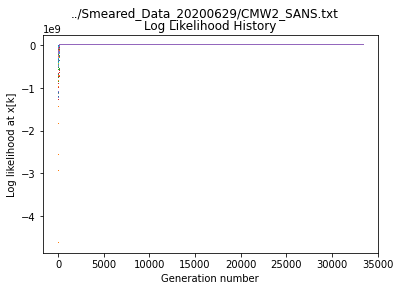

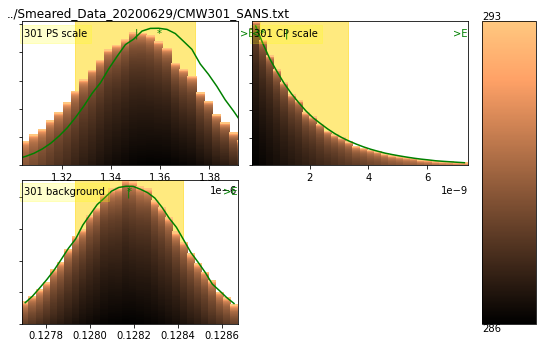

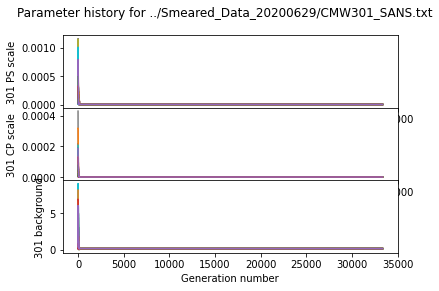

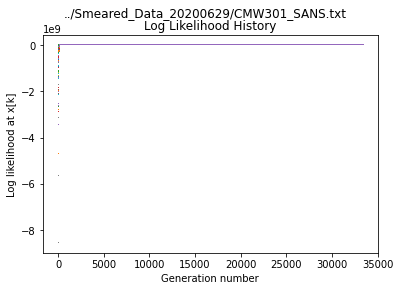

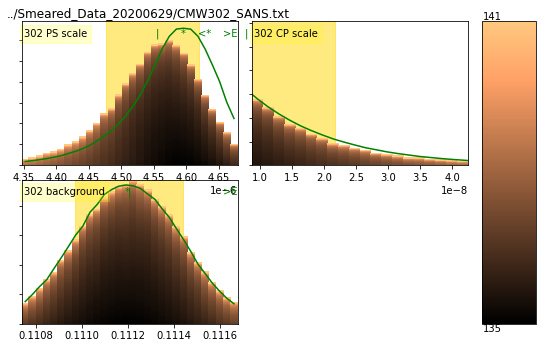

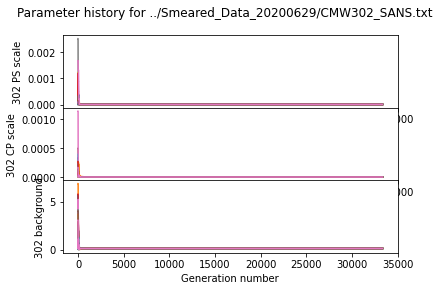

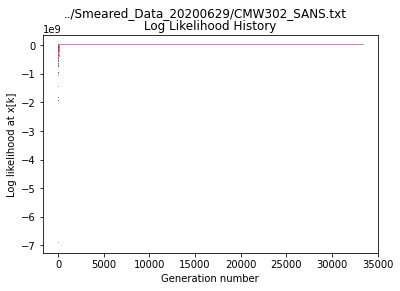

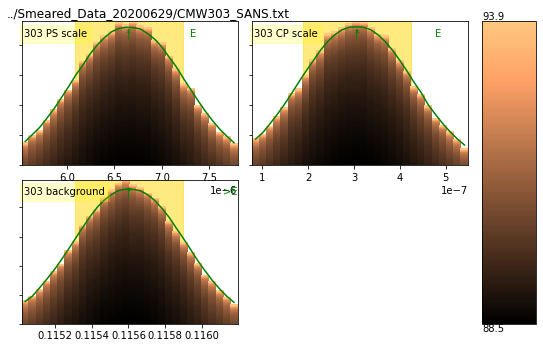

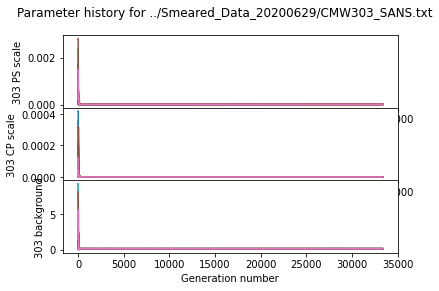

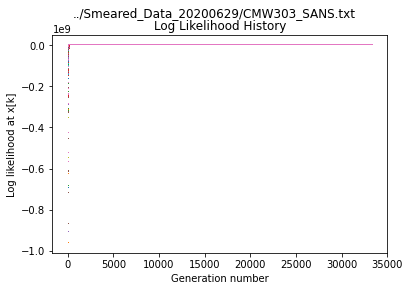

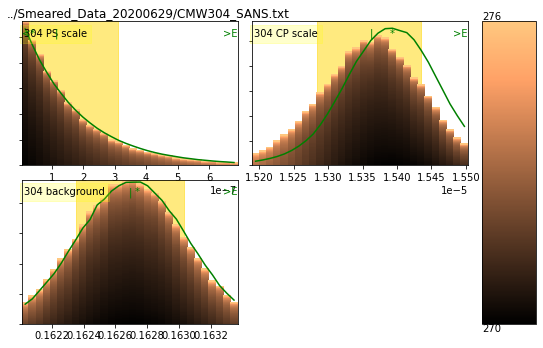

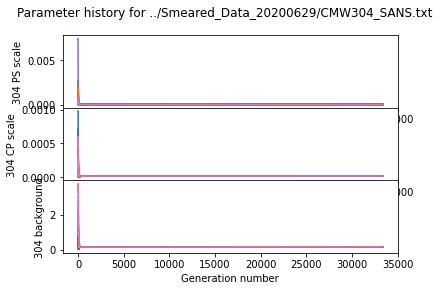

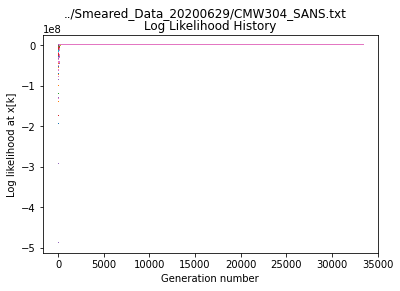

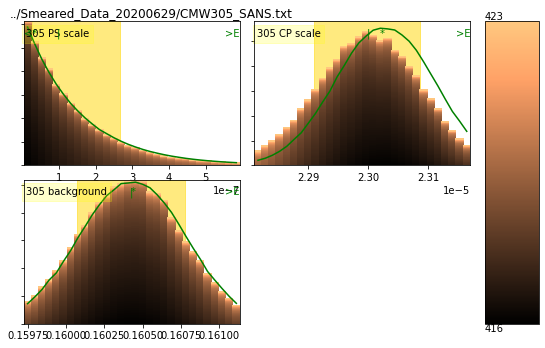

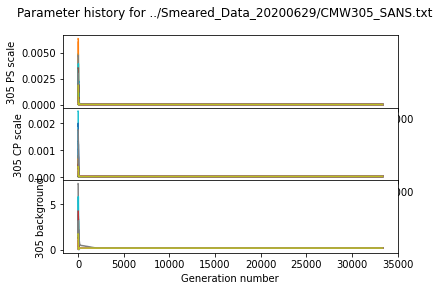

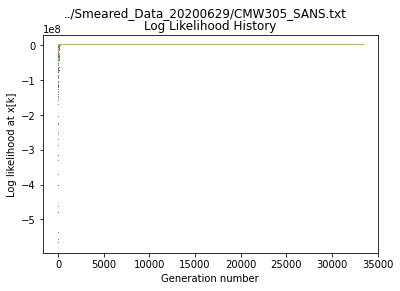

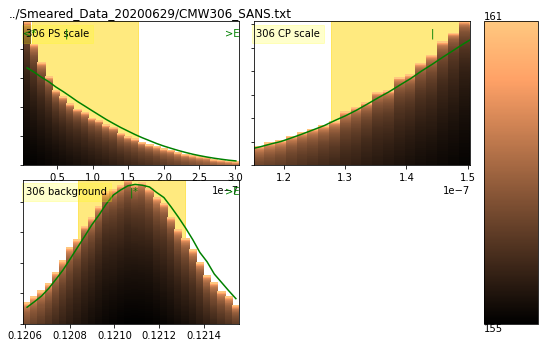

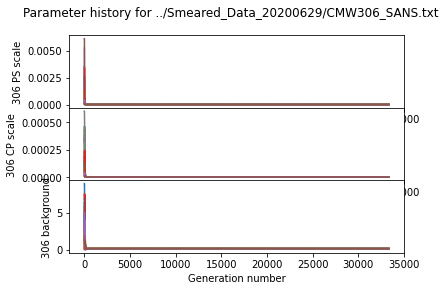

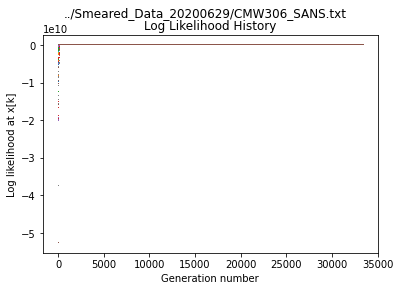

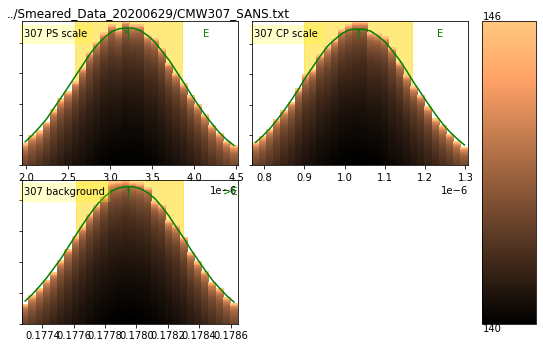

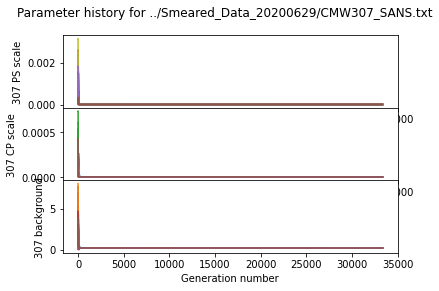

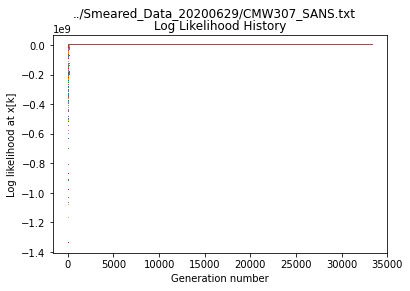

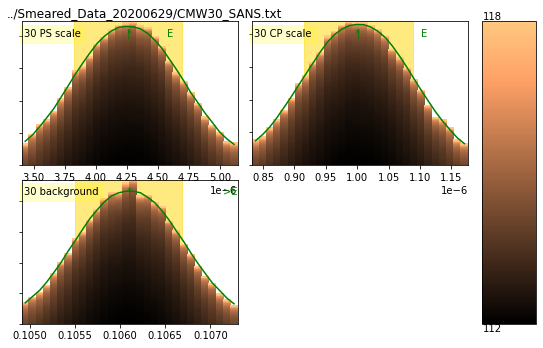

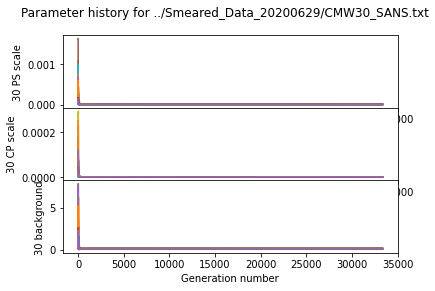

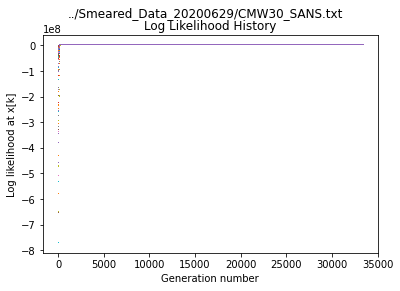

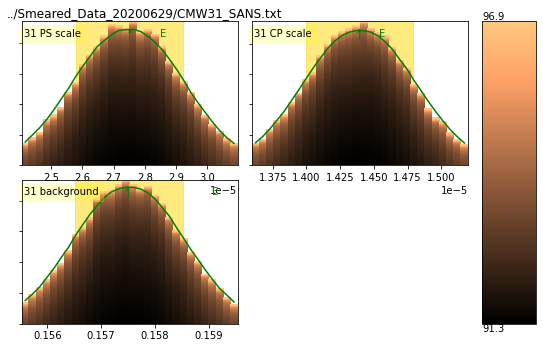

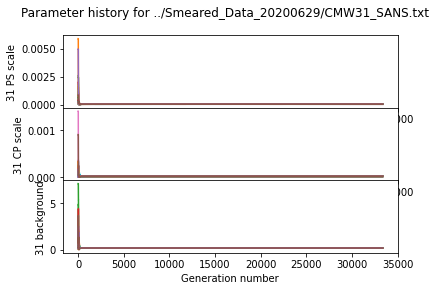

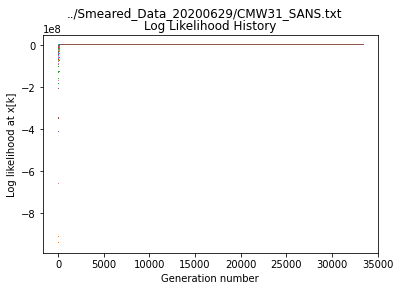

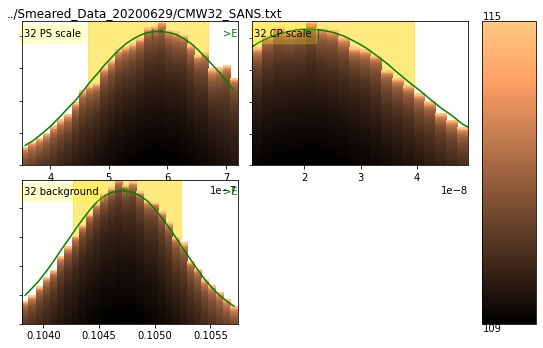

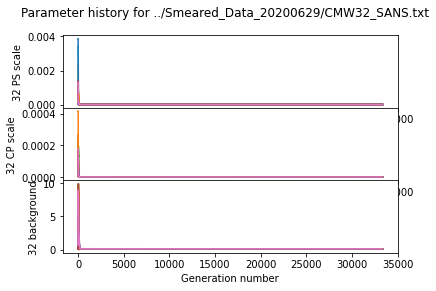

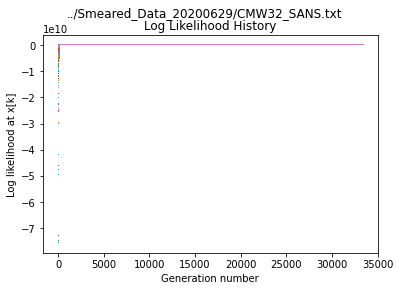

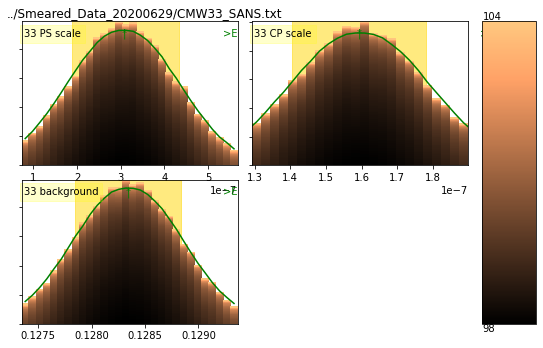

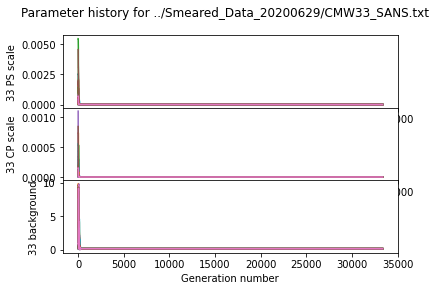

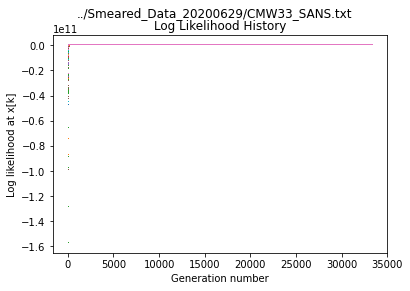

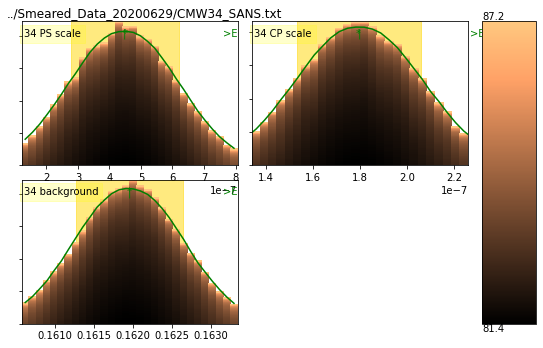

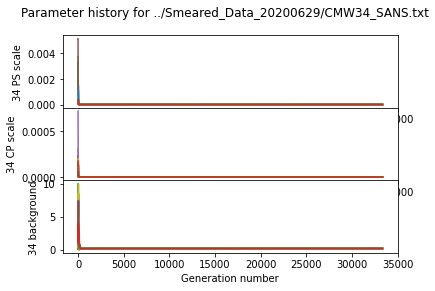

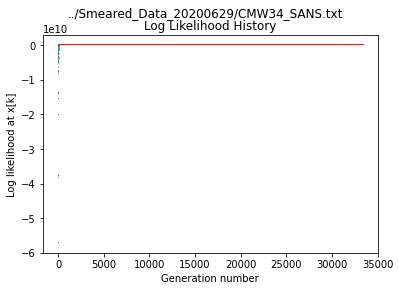

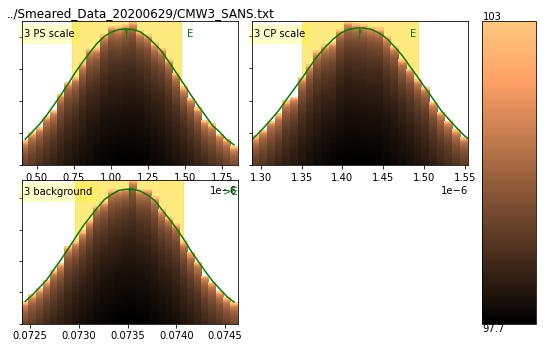

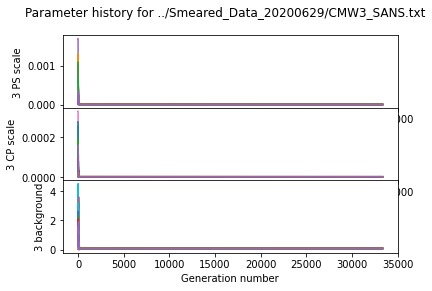

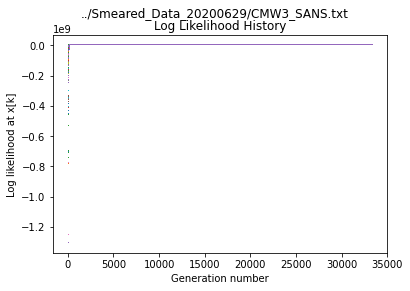

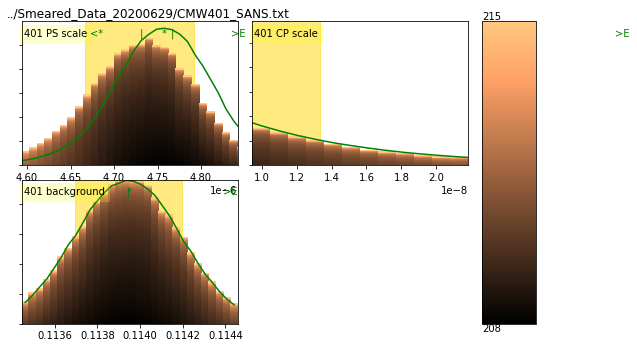

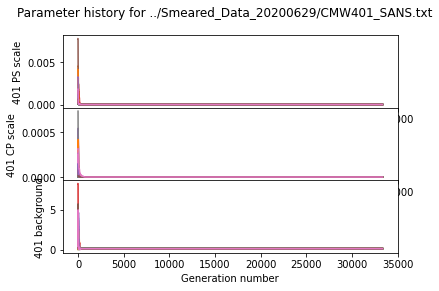

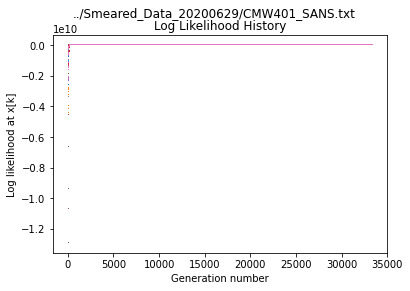

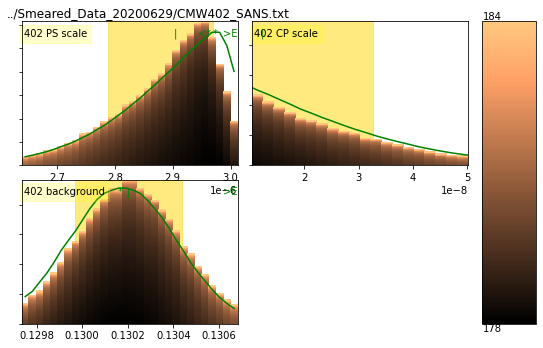

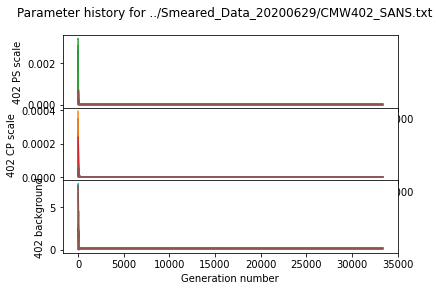

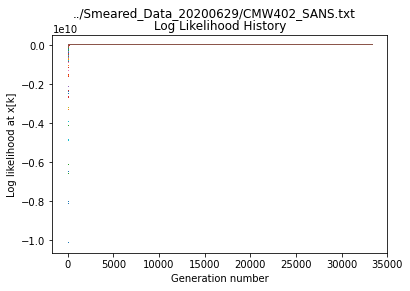

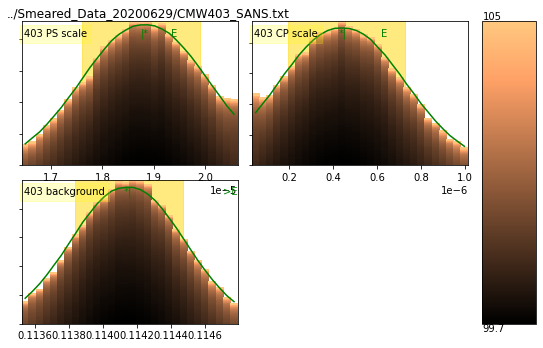

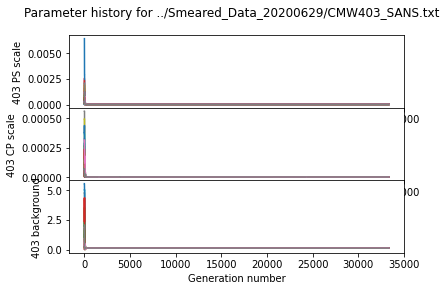

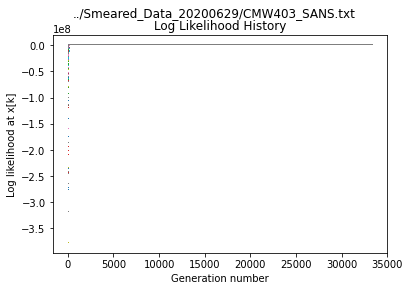

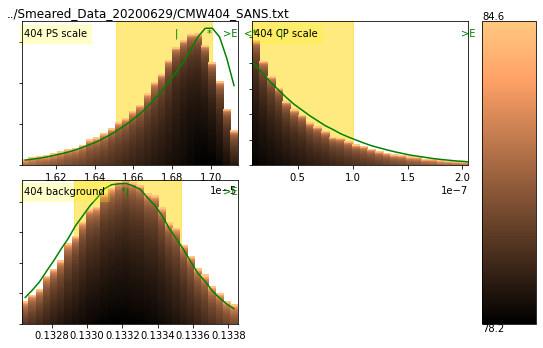

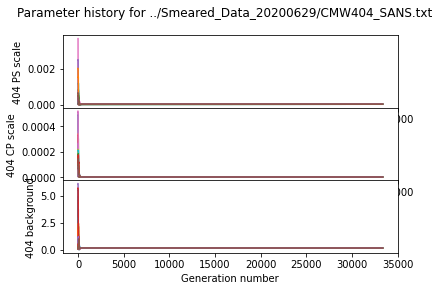

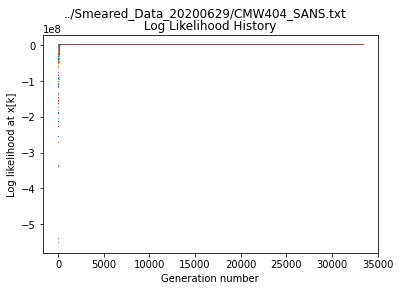

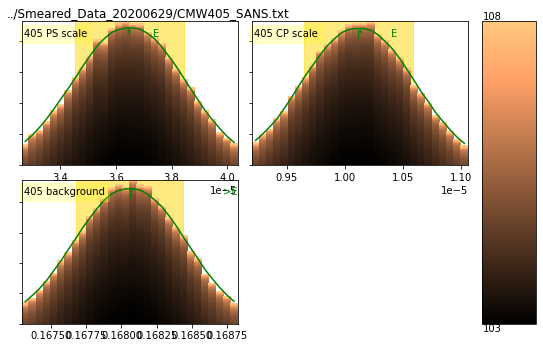

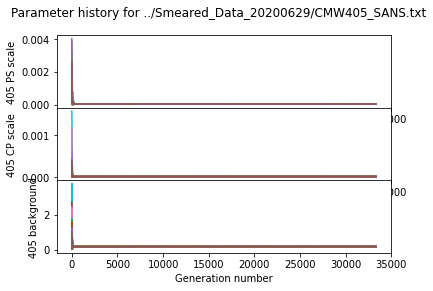

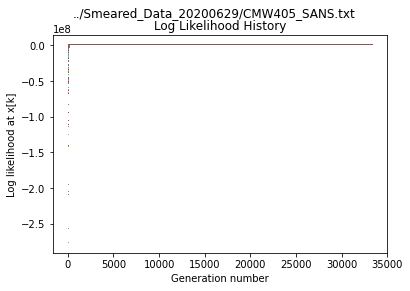

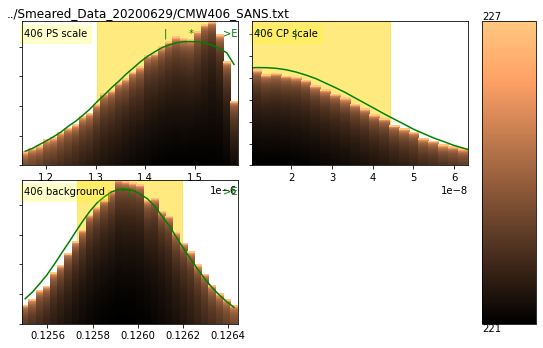

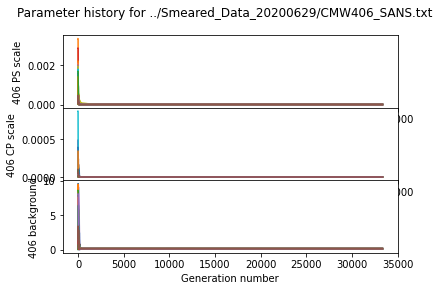

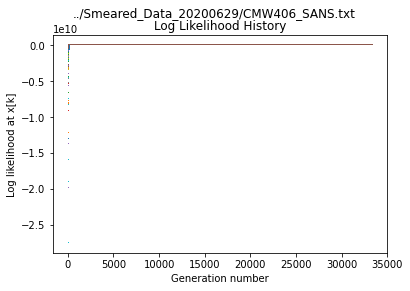

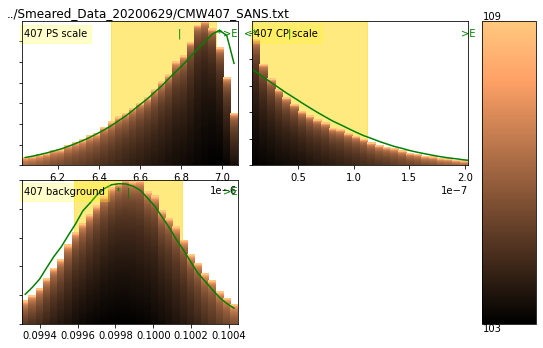

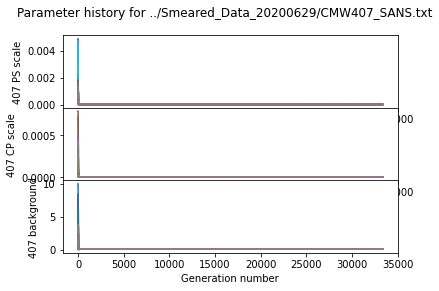

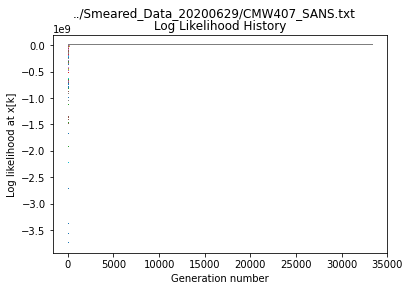

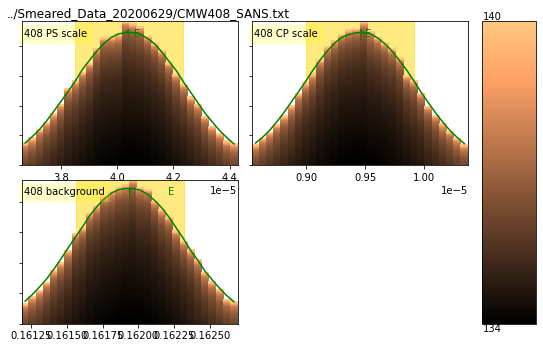

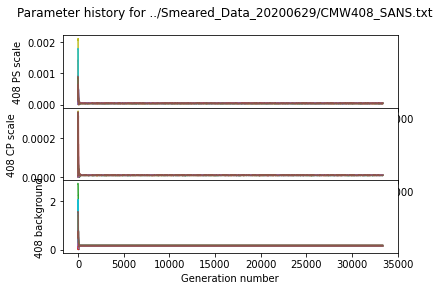

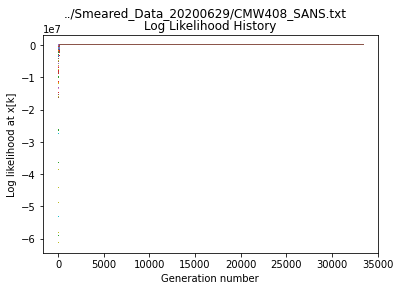

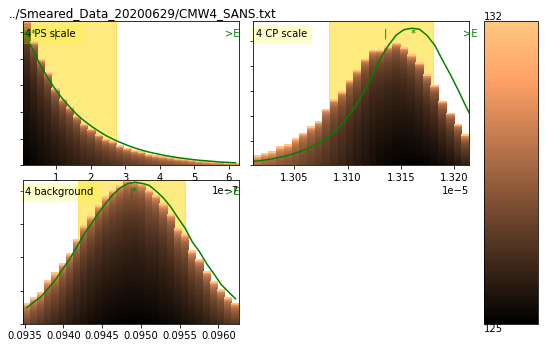

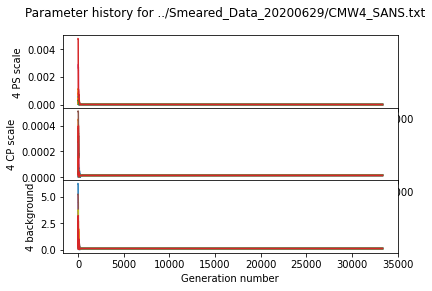

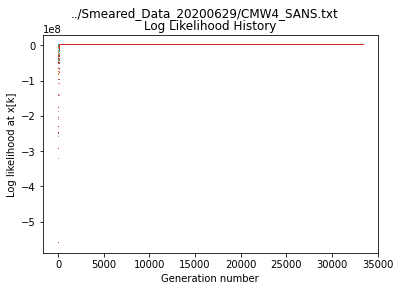

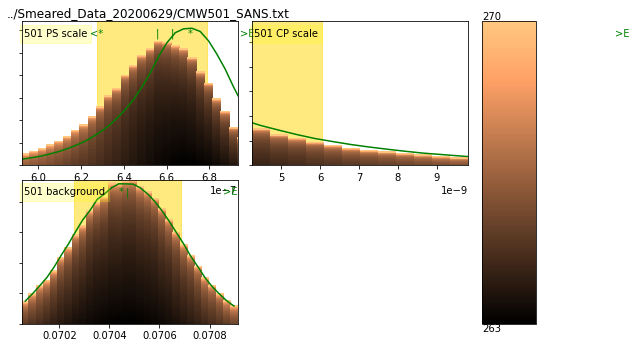

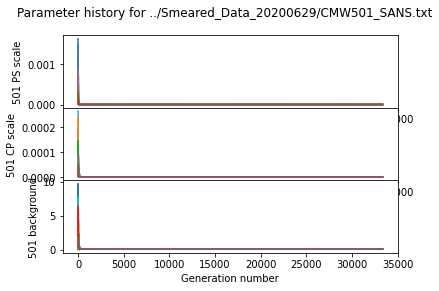

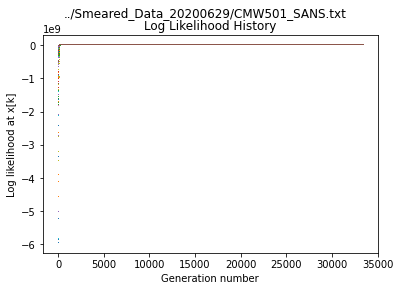

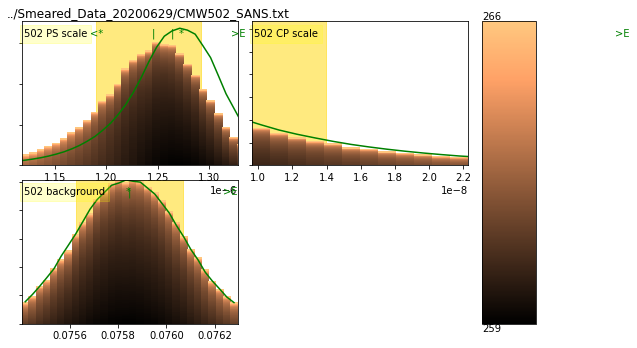

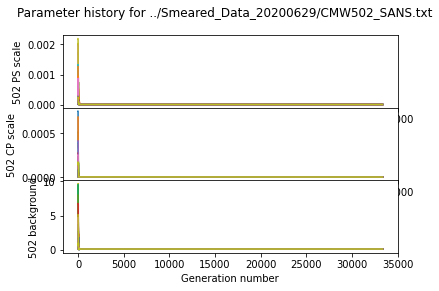

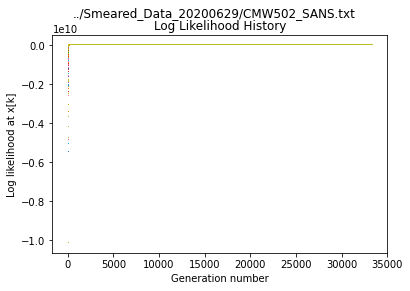

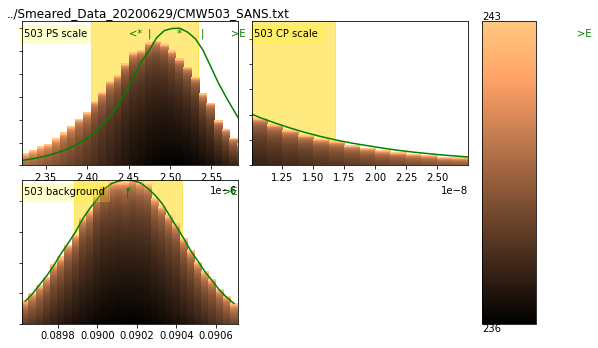

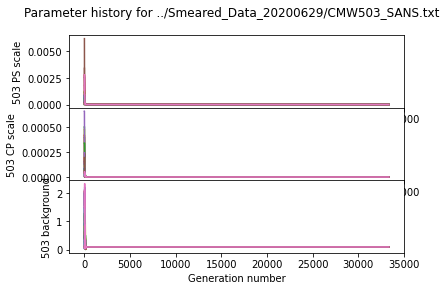

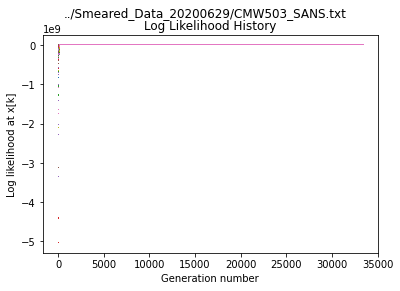

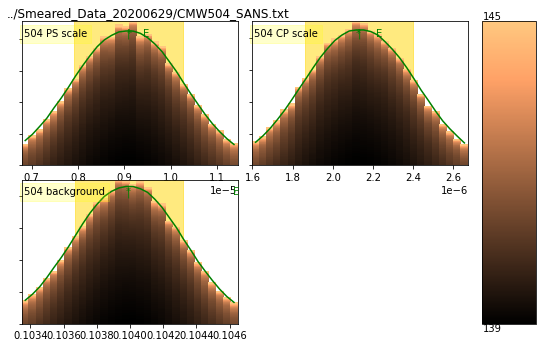

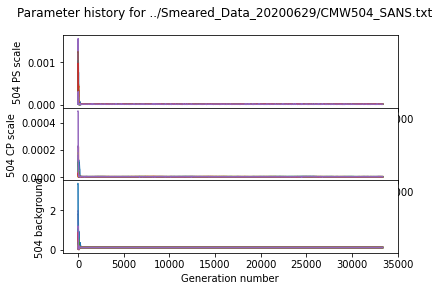

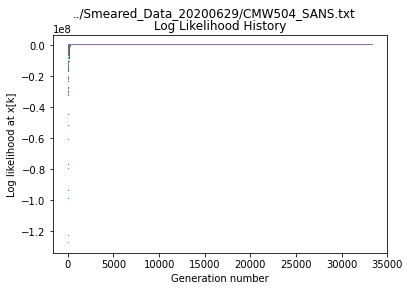

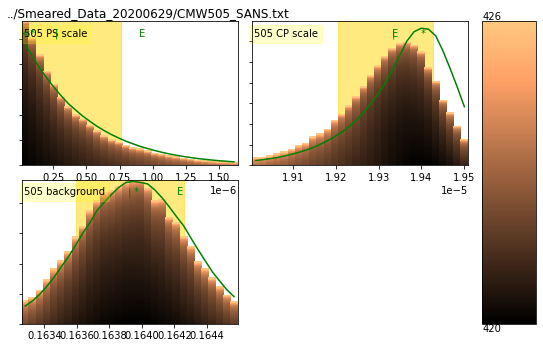

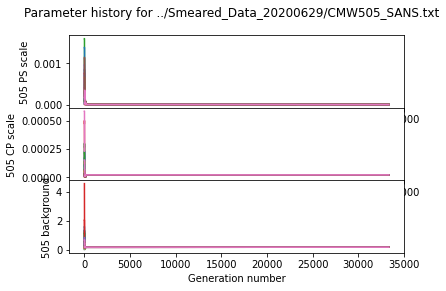

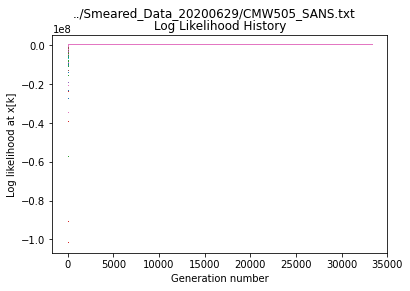

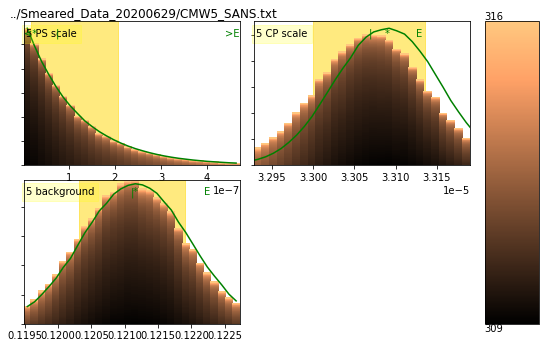

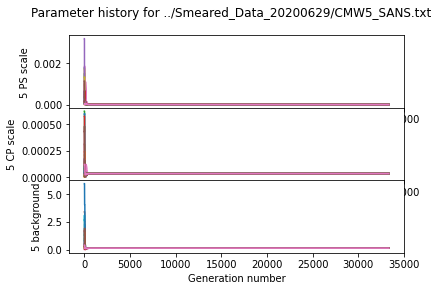

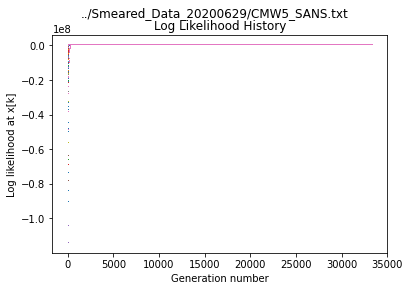

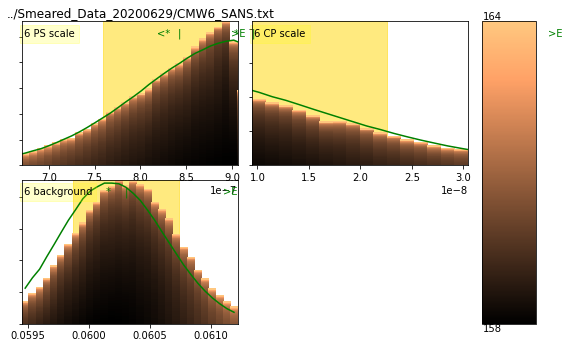

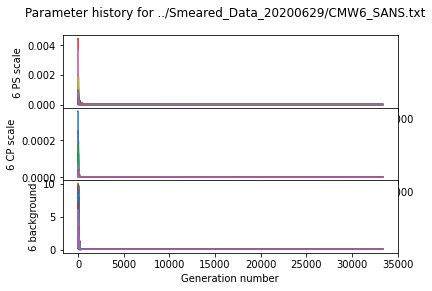

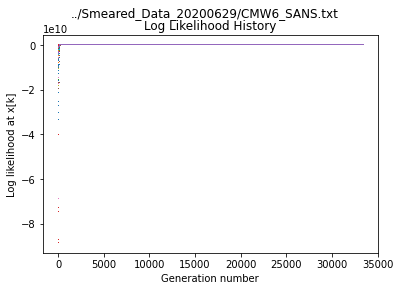

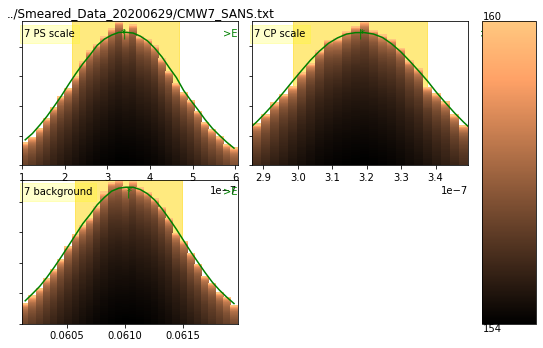

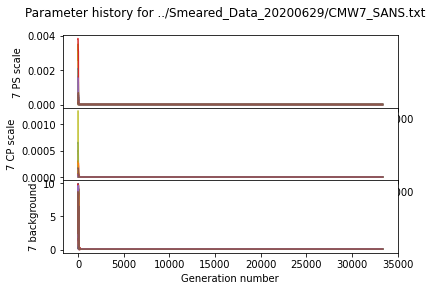

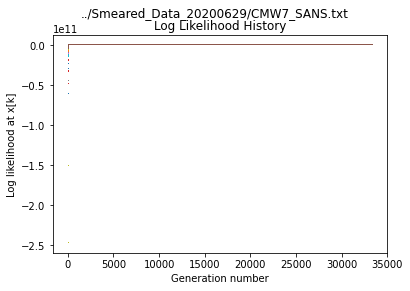

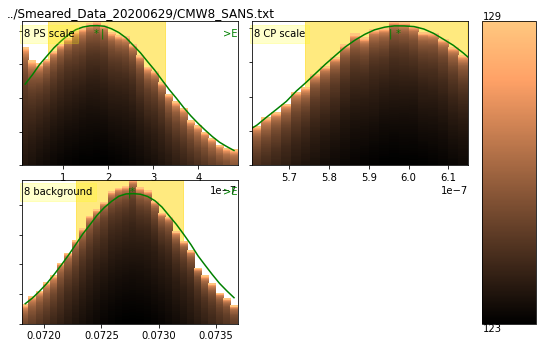

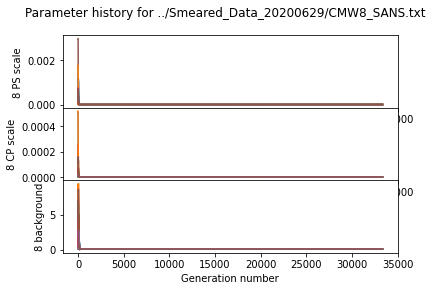

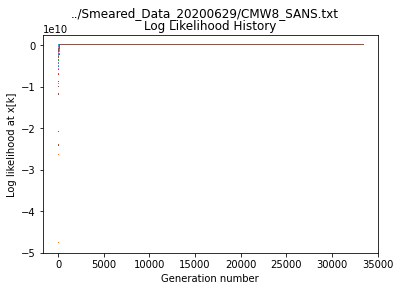

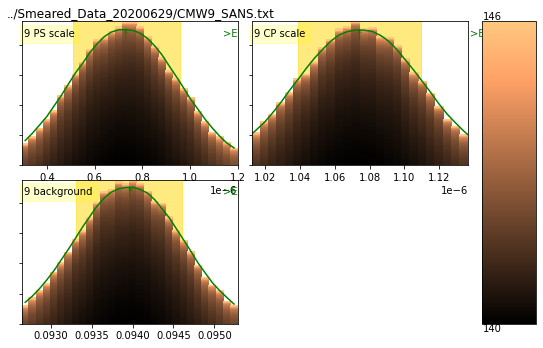

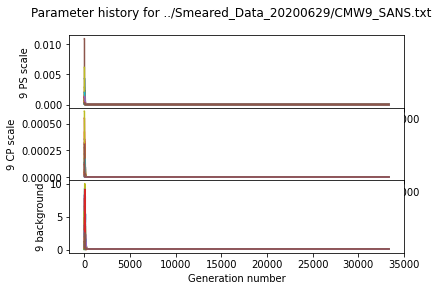

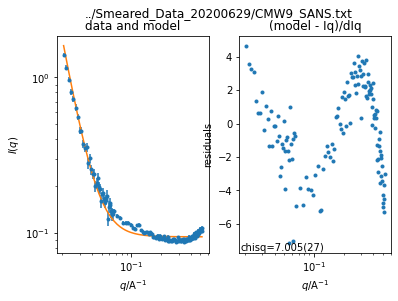

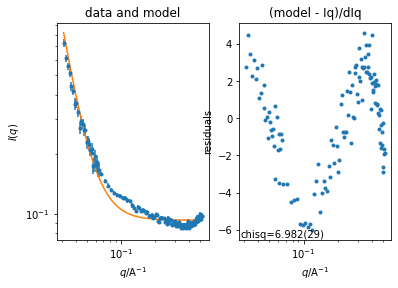

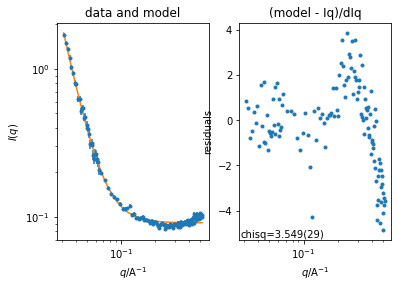

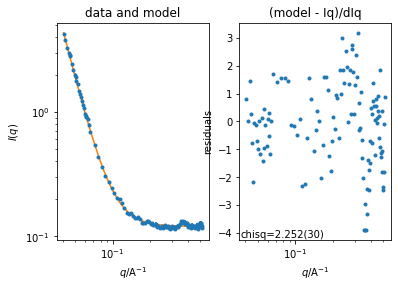

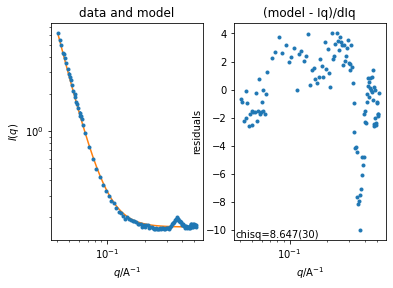

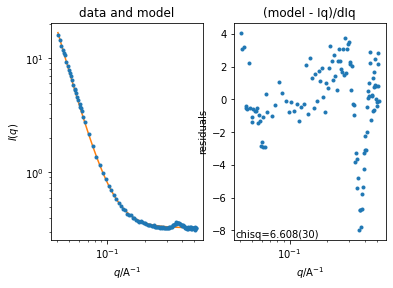

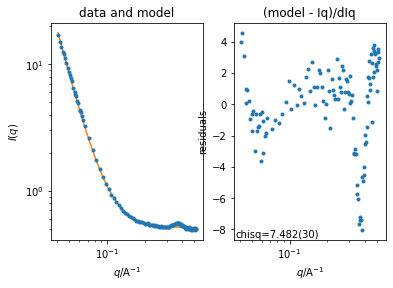

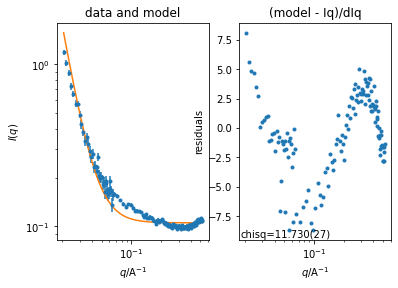

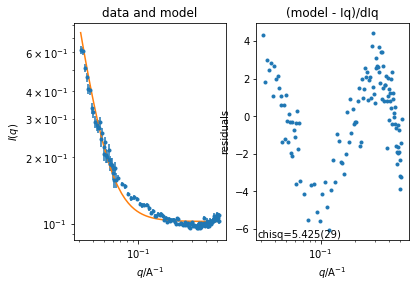

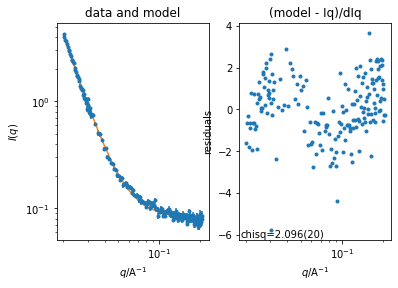

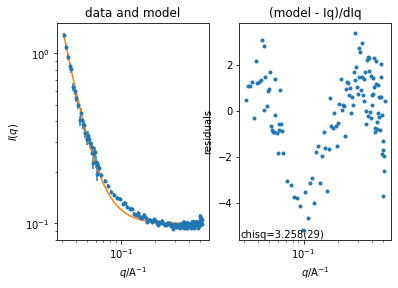

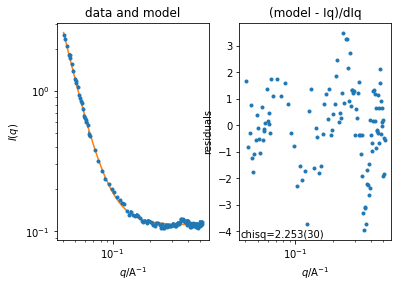

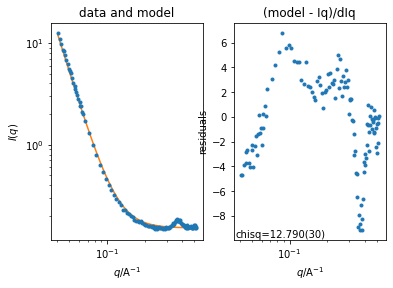

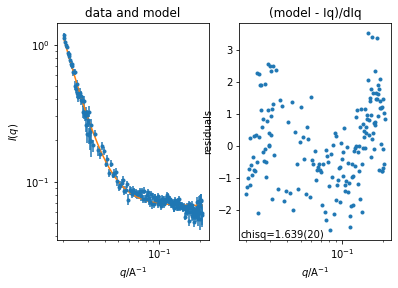

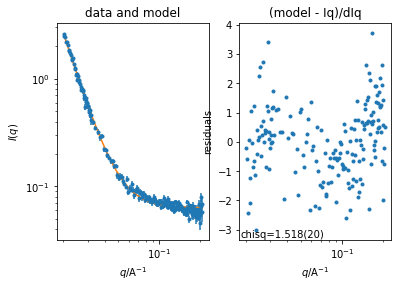

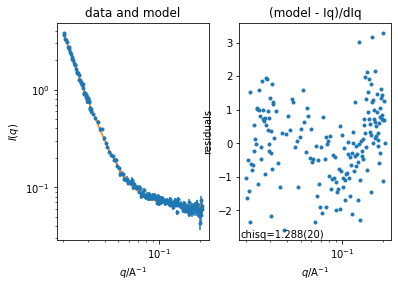

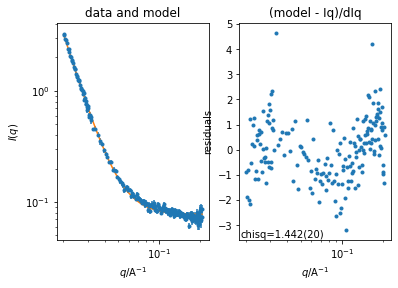

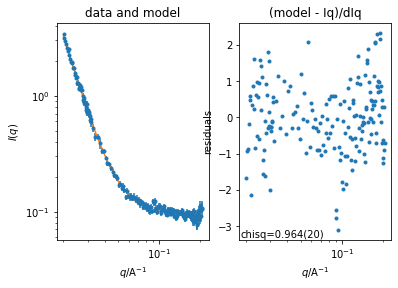

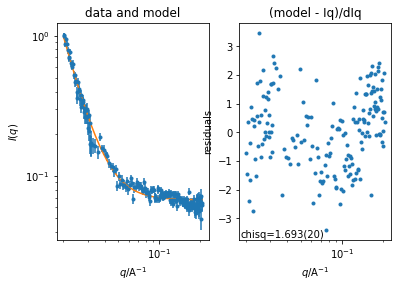

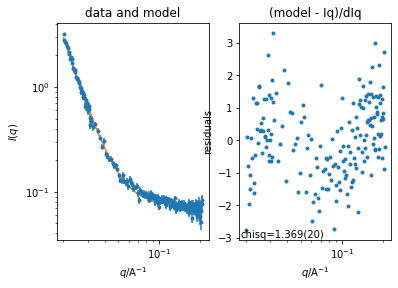

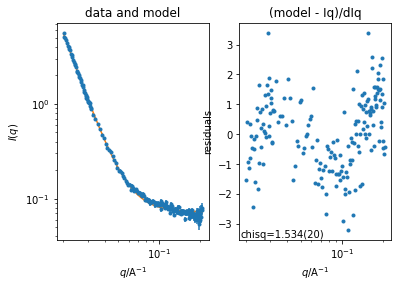

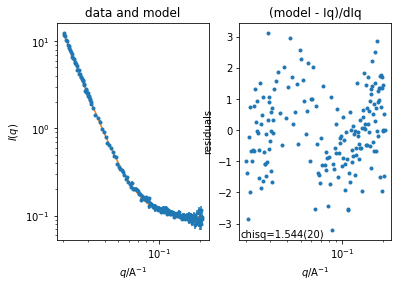

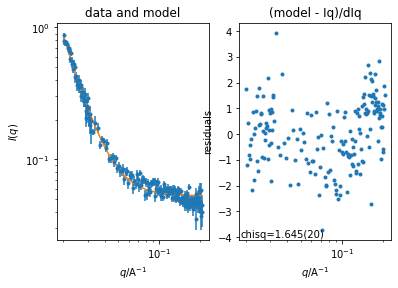

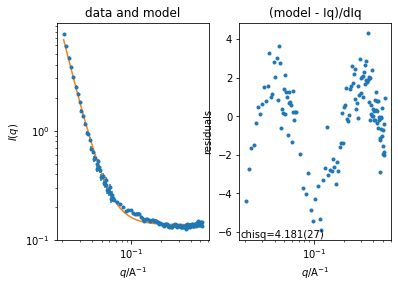

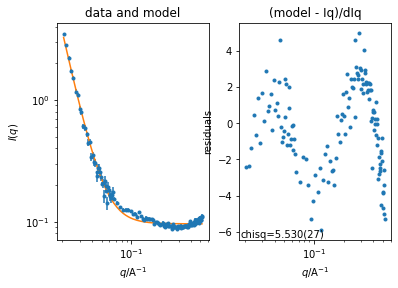

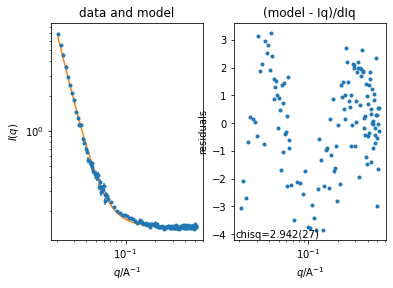

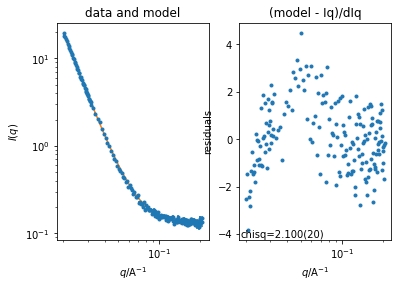

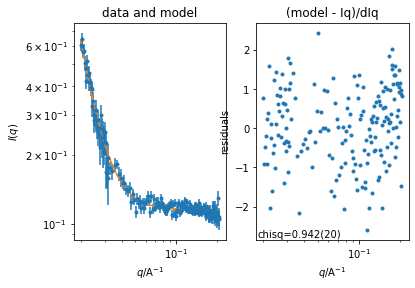

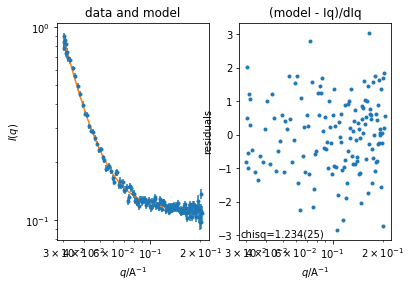

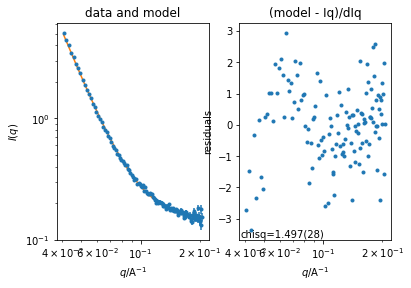

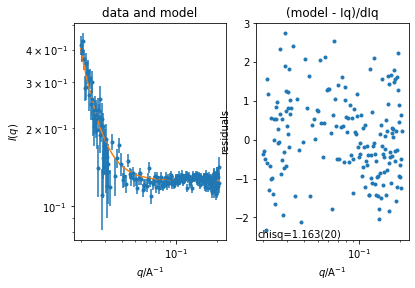

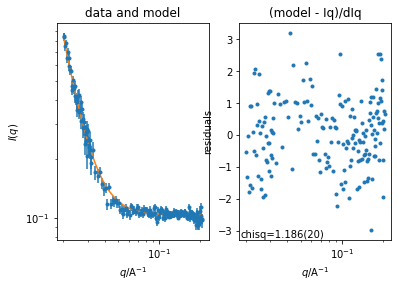

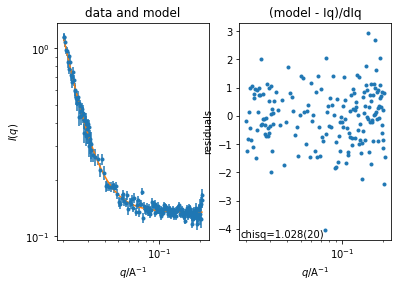

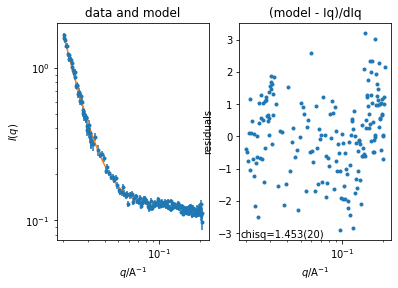

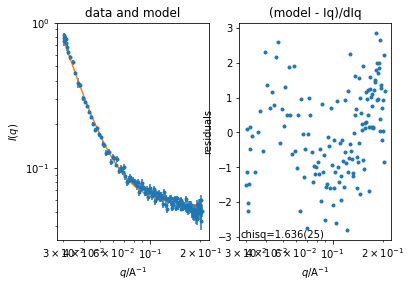

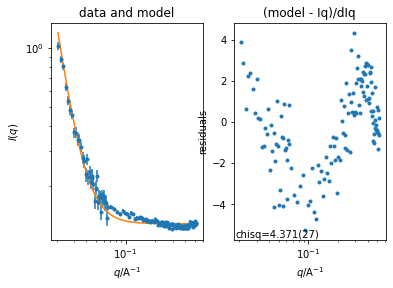

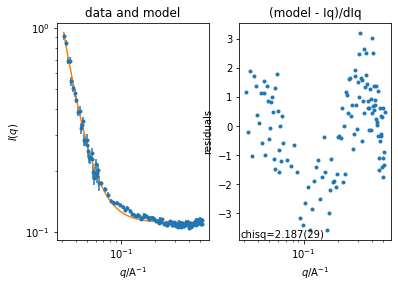

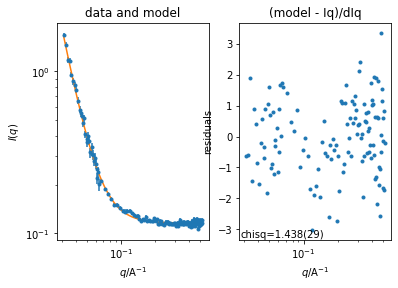

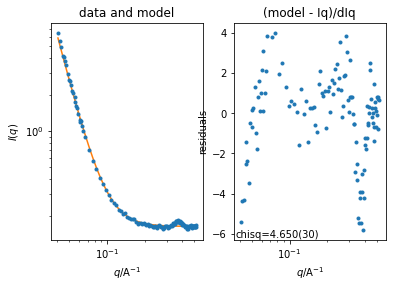

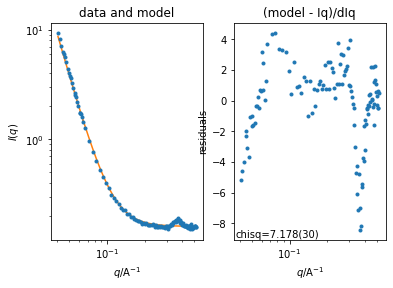

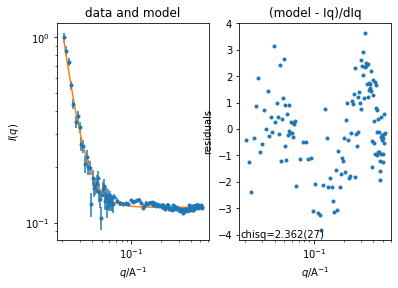

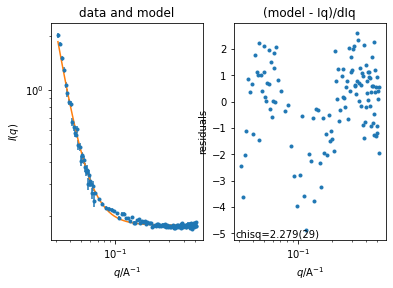

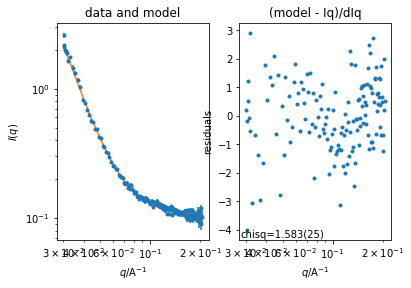

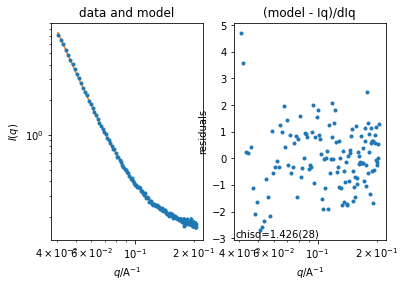

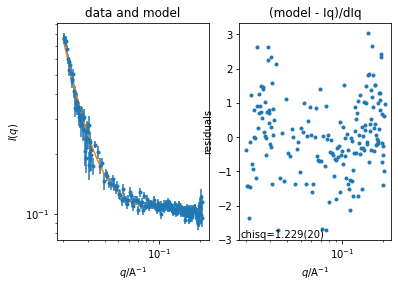

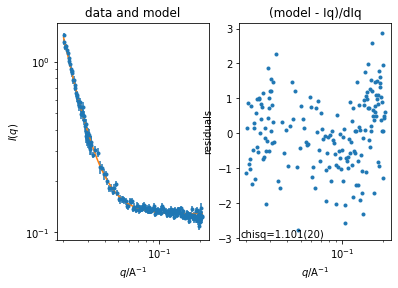

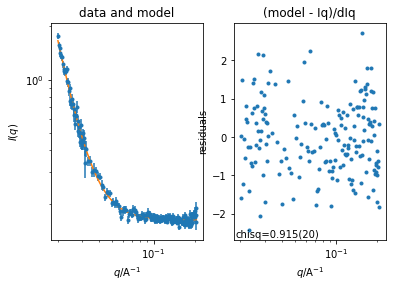

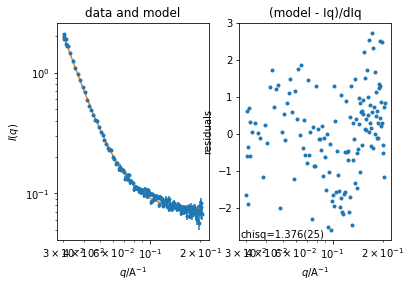

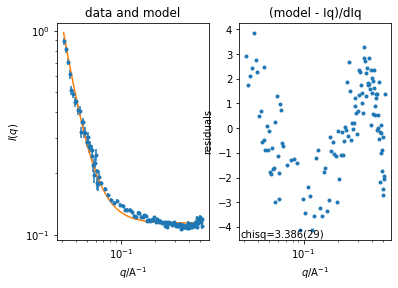

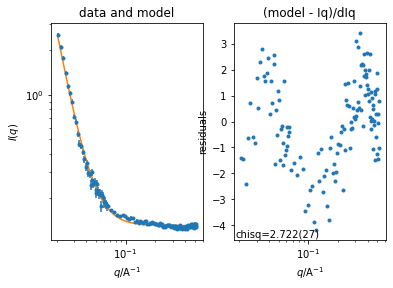

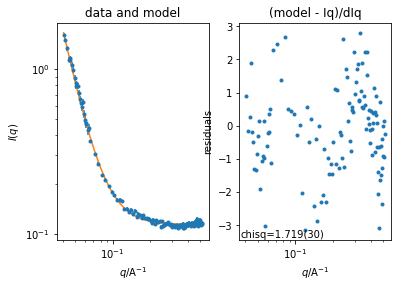

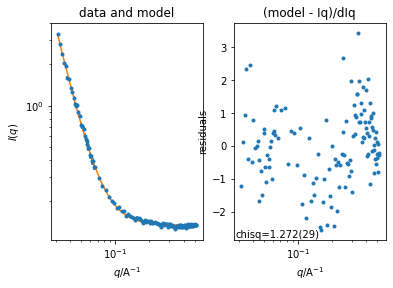

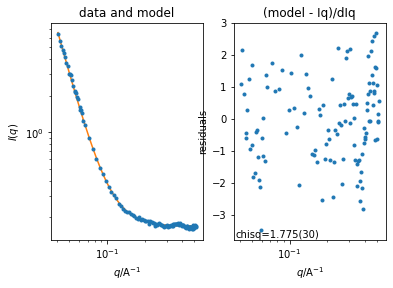

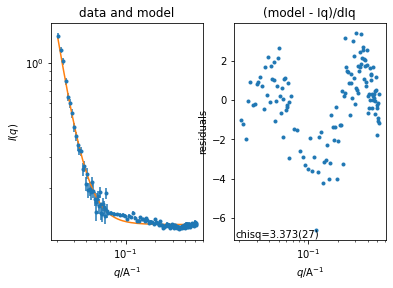

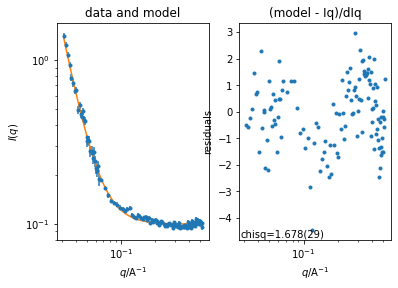

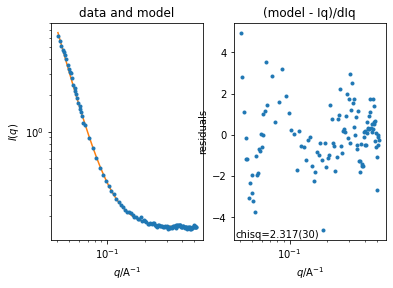

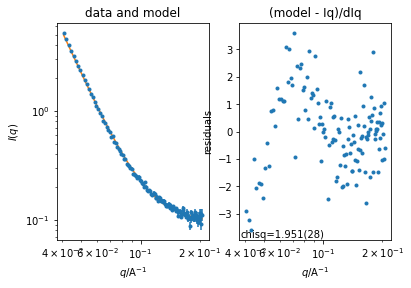

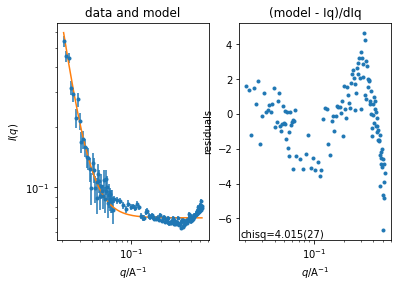

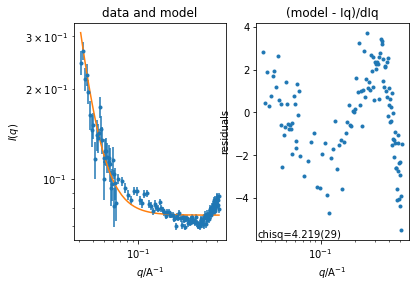

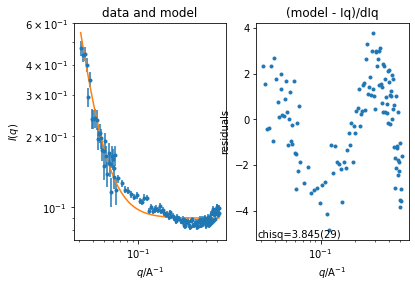

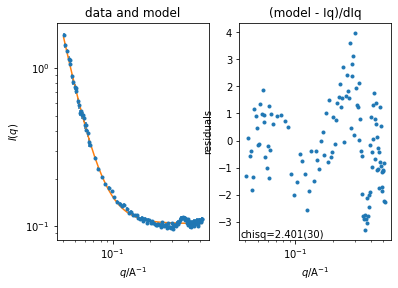

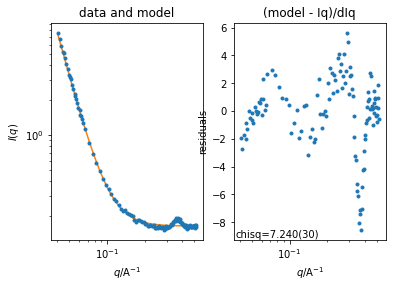

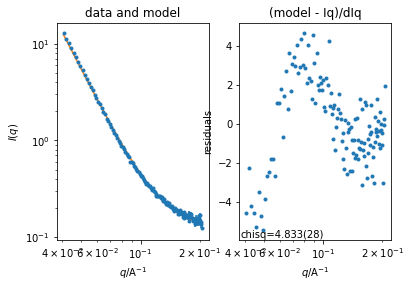

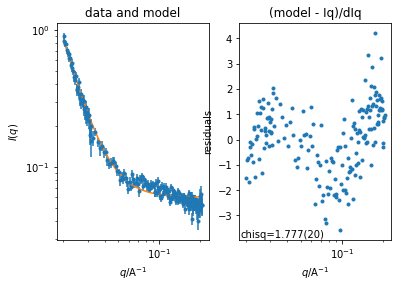

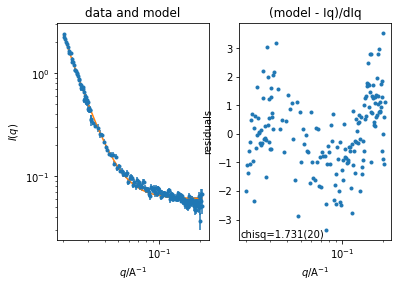

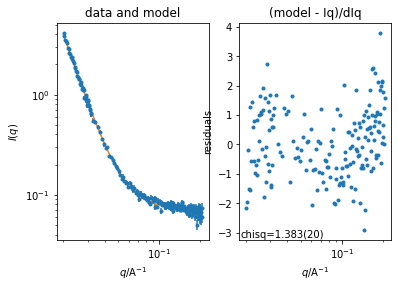

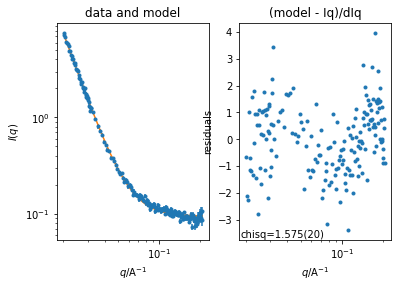

In [13]:
for problem in results.values():
    problem.plot()
    plt.show()
    plt.close()